###  House Prices: Advanced Regression Techniques
#### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.
#### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

#### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import (detect_outliers,one_hot_dataframe)
from datatools.dfloader import DataFrameLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
 
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
#colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

#sns.set_palette(sns.color_palette(colors))

#### Helper functions defined 

In [2]:
def plot_dataset(dataset,features ,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)

   
    for subplot_index ,i in enumerate(range(0,len(features))):
        if(features[i] != response_column ):
            ax = fig.add_subplot(3, 4,  subplot_index + 1)
            if log:
                ax.set(xscale="log",yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.regplot(x=features[i],y= response_column , marker="+", data = dataset,ax=ax)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            plt.tight_layout()
 
    plt.show()

In [3]:
def check_null(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    print("<{0} {1} {0}>".format("="*35,"Dataset null value count"))
    print(null_sum.sort_values(ascending=False))

---
#### Mainline

In [4]:
load_app_config()
DIRECTORY="kaggle_housing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'SalePrice'
input_path = get_datafolder_path()

train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
print(train_file)
print(test_file)



Adding F:\DataSource  to system path
Adding F:\MachineLearning  to system path
F:\DataSource\kaggle_housing\train.csv
F:\DataSource\kaggle_housing\test.csv


In [5]:
train_loader = DataFrameLoader(train_file, sep=',',header=0 ,encoding='utf8')
test_loader  = DataFrameLoader(test_file, sep=',',header=0 ,encoding='utf8')
 
#features  = [column for column in train_loader.dataframe.columns.values if column != RESPONSE]

X_train =train_loader.dataframe 
y_train =train_loader.dataframe[[RESPONSE]]
X_test = test_loader.dataframe 

In [6]:
# Default continuous and categorical features
X_train_continuous = train_loader.continuous_dataframe
X_test_continuous = test_loader.continuous_dataframe
X_train_categorical = train_loader.categorical_dataframe
X_test_categorical = test_loader.categorical_dataframe


In [7]:
print(X_train.shape)
print(X_test.shape)

(1460, 81)
(1459, 80)


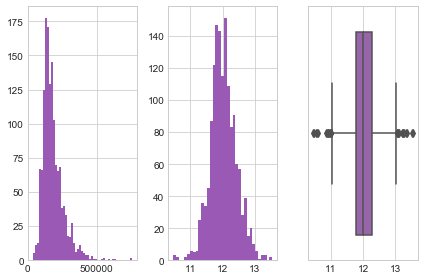

In [8]:
#log transformed SalePrice histogram  and boxplot - looks much like normal distribution now. 

fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(1,3, 1)
sns.distplot(X_train_continuous[[RESPONSE]],ax=ax1 ,kde =False,hist_kws=dict(alpha=1))
ax2 = fig.add_subplot(1,3, 2)
sns.distplot(np.log1p(X_train_continuous[[RESPONSE]]),ax=ax2 ,kde =False,hist_kws=dict(alpha=1))
ax3 = fig.add_subplot(1,3, 3)
sns.boxplot(x=np.log1p(X_train_continuous[[RESPONSE]]),ax=ax3)
plt.tight_layout()
plt.show()

In [9]:
ordinal_category =['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

In [10]:
continuous_features = [ feature for feature in train_loader.continuous_features if feature not in ordinal_category]
categorical_features = train_loader.categorical_features
categorical_features.extend(ordinal_category)
#continuous_features.remove('Id') ### we will drop it later we require it for analysis 
### SalePrice is not existing in test set 
continuous_features  =[feature for feature in continuous_features if feature !=RESPONSE]

In [11]:
print("size of categorical features :{}".format(len(categorical_features)))
print("size of continuous  features :{}".format(len(continuous_features)))

X_train_continuous = train_loader.dataframe[continuous_features]
check_null(X_train_continuous)

X_test_continuous = test_loader.dataframe[continuous_features]
check_null(X_test_continuous)
X_train[continuous_features].head()

size of categorical features :51
size of continuous  features :29
<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


Id  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal
0   1         65.0     8450       196.0         706           0        150          856       856       854             0       1710             1             0         2         1             3             1             8           0           2         548           0           61              0          0            0         0        0
1   2         80.0     9600         0.0         978           0        284         1262      1262         0             0       1262             0             1         2         0             3             1             6           1           2         460         298            0              0          0            0         0        0
2   3         68.0    11250       162.0         486           0        434          920       920       866             0       1786             1             0         2         1             3             1             6           1           2         608           0           42              0          0            0         0        0
3   4         60.0     9550         0.0         216           0        540          756       961       756             0       1717             1             0         1         0             3             1             7           1           3         642           0           35            272          0            0         0        0
4   5         84.0    14260       350.0         655           0        490         1145      1145      1053             0       2198             1             0         2         1             4             1             9           1           3         836         192           84              0          0            0         0        0

---
### Cleaning Datasets
#### Identifying missing values in data
#### Imputing (filling in) these missing values
#### Normalizing/standardizing data
---

In [12]:
X_train[continuous_features].iloc[:,0:10].head()

Id  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF
0   1         65.0     8450       196.0         706           0        150          856       856       854
1   2         80.0     9600         0.0         978           0        284         1262      1262         0
2   3         68.0    11250       162.0         486           0        434          920       920       866
3   4         60.0     9550         0.0         216           0        540          756       961       756
4   5         84.0    14260       350.0         655           0        490         1145      1145      1053

In [13]:
X_train[continuous_features].iloc[:,0:10].describe()

Id  LotFrontage      LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF   1stFlrSF   2ndFlrSF
count  1460.00    1201.0000    1460.0000   1452.0000   1460.0000   1460.0000  1460.0000    1460.0000  1460.0000  1460.0000
mean    730.50      70.0500   10516.8281    103.6853    443.6397     46.5493   567.2404    1057.4295  1162.6267   346.9925
std     421.61      24.2848    9981.2649    181.0662    456.0981    161.3193   441.8670     438.7053   386.5877   436.5284
min       1.00      21.0000    1300.0000      0.0000      0.0000      0.0000     0.0000       0.0000   334.0000     0.0000
25%     365.75      59.0000    7553.5000      0.0000      0.0000      0.0000   223.0000     795.7500   882.0000     0.0000
50%     730.50      69.0000    9478.5000      0.0000    383.5000      0.0000   477.5000     991.5000  1087.0000     0.0000
75%    1095.25      80.0000   11601.5000    166.0000    712.2500      0.0000   808.0000    1298.2500  1391.2500   728.0000
max    1460.00     313.0000  215245.0000   1600.0000   5644.0000   1474.0000  2336.0000    6110.0000  4692.0000  2065.0000

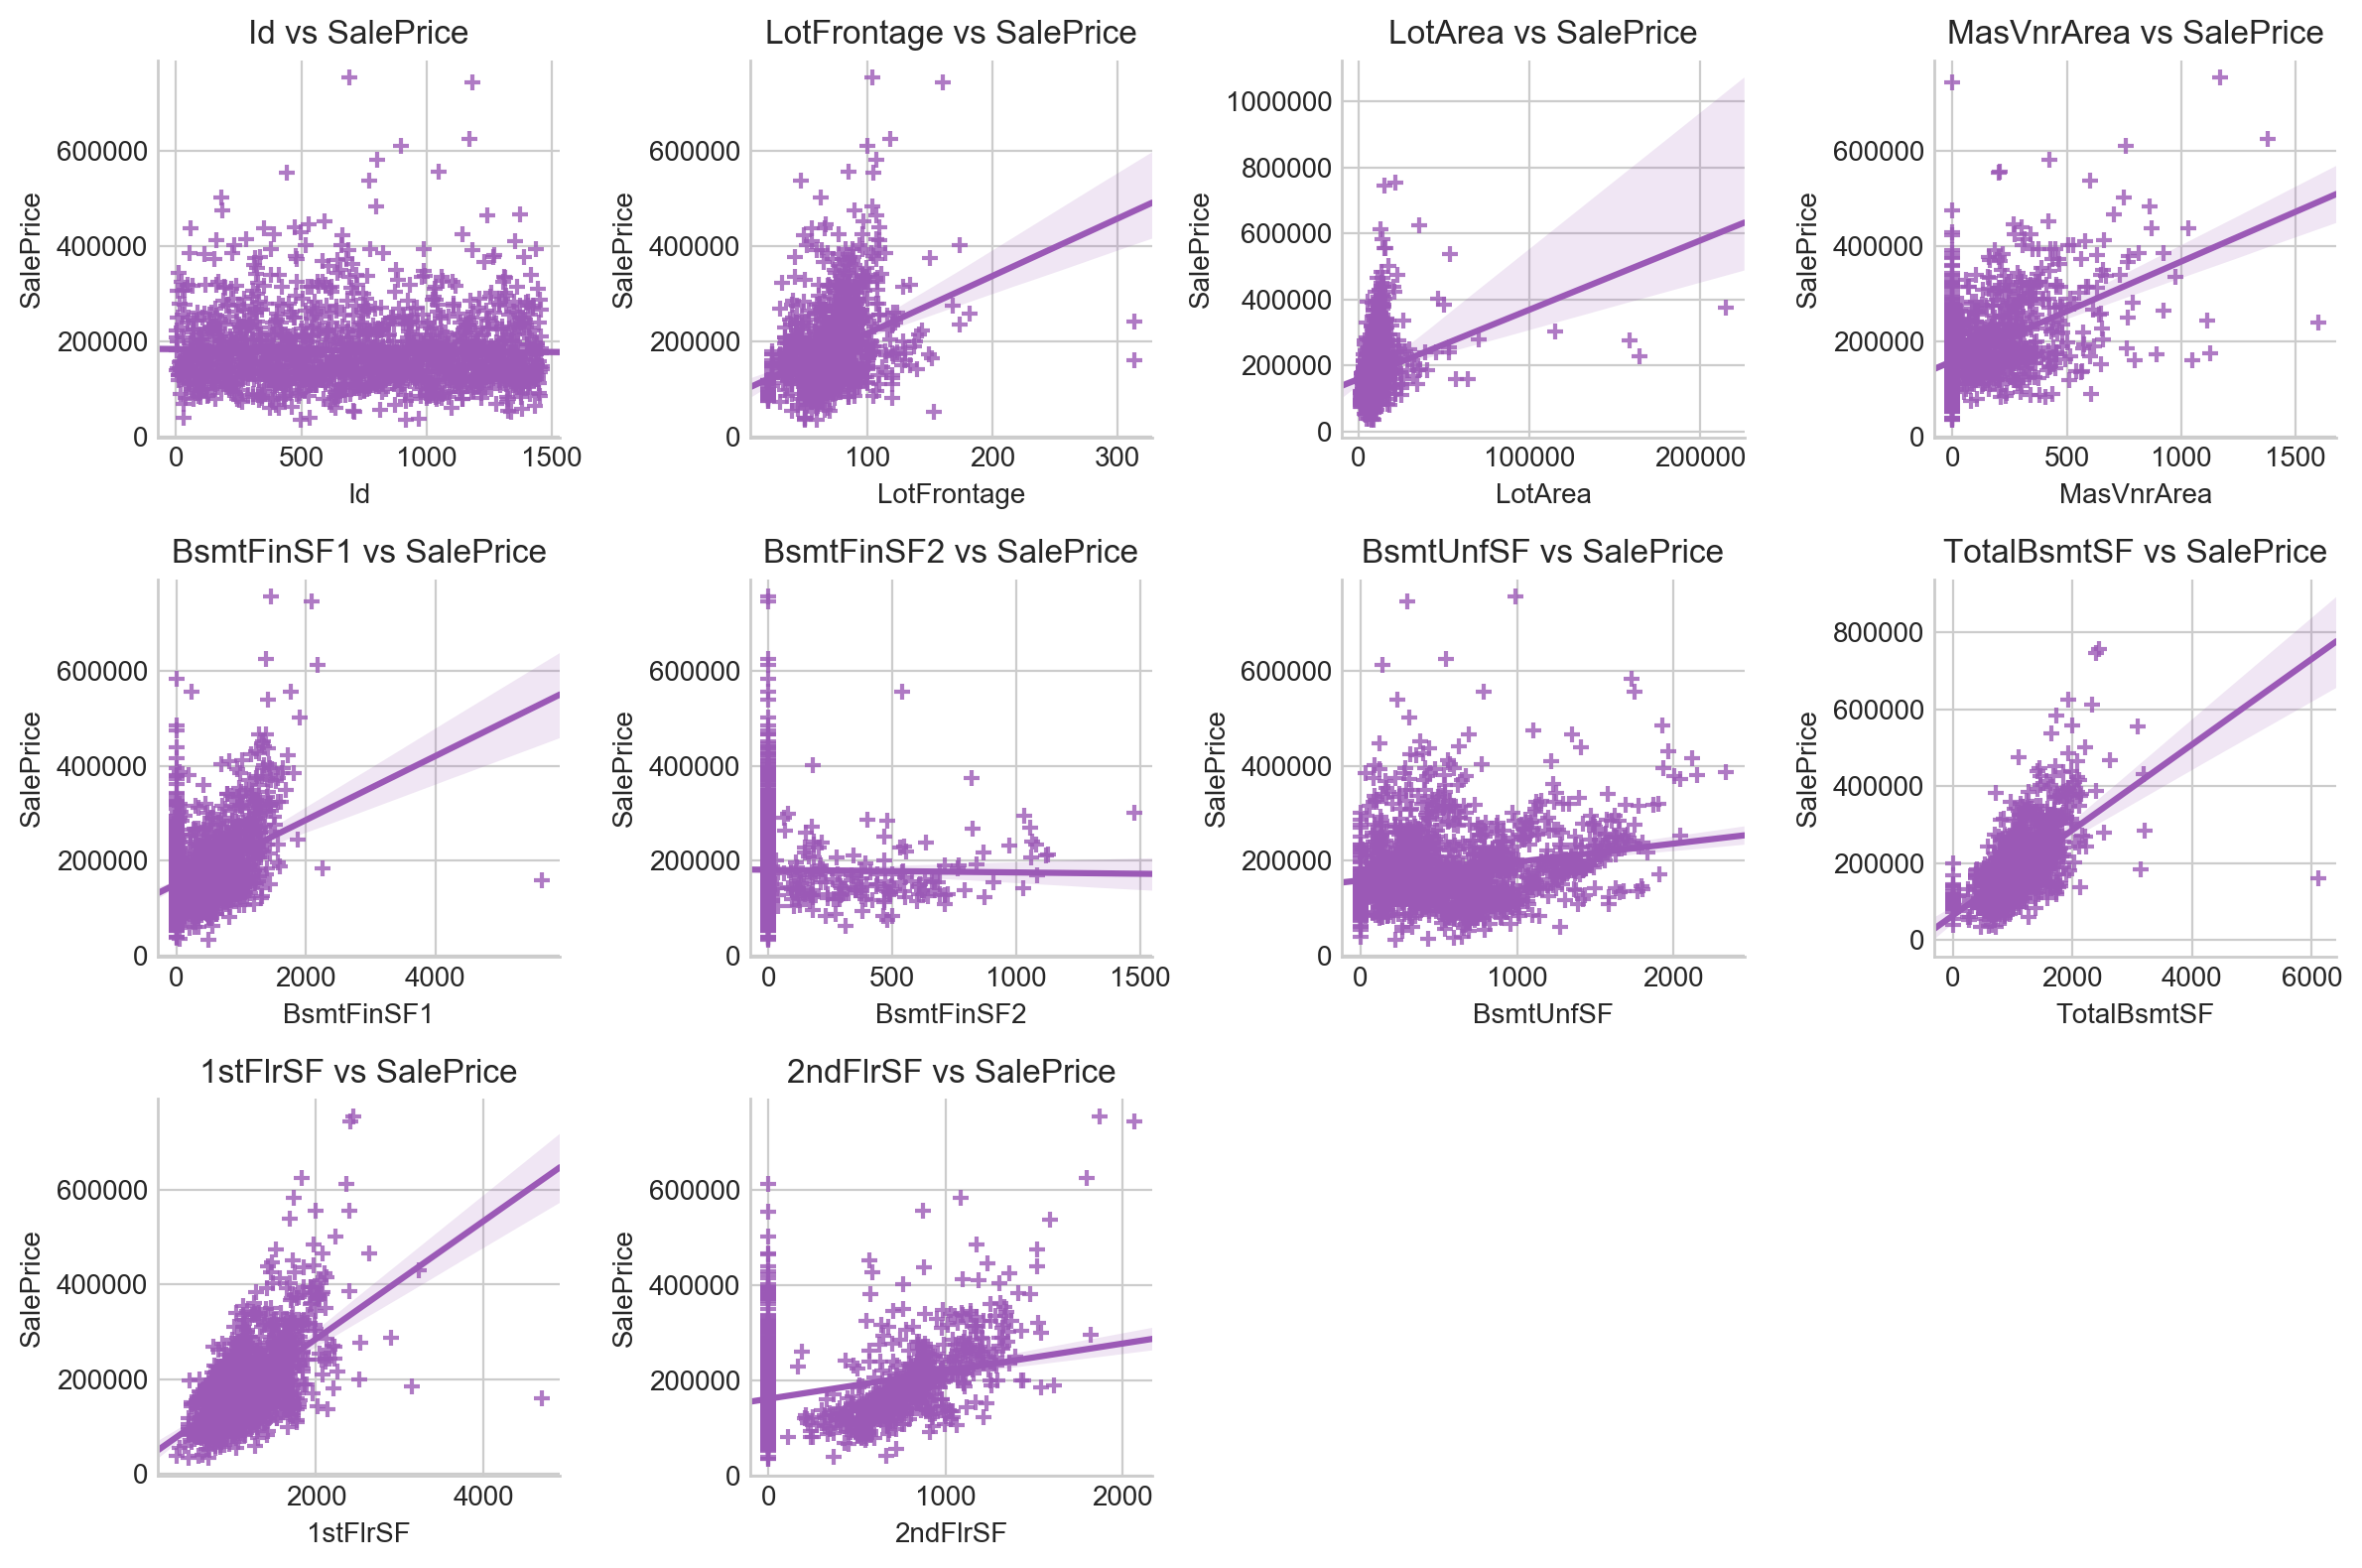

In [14]:
plot_dataset(X_train ,continuous_features[0:10],RESPONSE,log=False)

#### Inferences
###### OverallQual,OverallCond  are ordinal columns
###### MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF ,TotalBsmtSF have minimum value as  zero - Need to verify
###### TotalBsmtSF =BsmtFinSF1 +BsmtFinSF2 + BsmtUnfSF   
###### LotArea ,LotFrontage ,MasVnrArea,TotalBsmtSF   has linear relation with SalePrice. However  these values need to be log transformed  to re-evaluvate


In [15]:
#plot_dataset(X_train_continuous,RESPONSE,0,12,log=True)

In [16]:
X_train[continuous_features].iloc[:,10:20].head()

LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces
0             0       1710             1             0         2         1             3             1             8           0
1             0       1262             0             1         2         0             3             1             6           1
2             0       1786             1             0         2         1             3             1             6           1
3             0       1717             1             0         1         0             3             1             7           1
4             0       2198             1             0         2         1             4             1             9           1

In [17]:
X_train[continuous_features].iloc[:,10:20].describe()

LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath   FullBath   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces
count     1460.0000  1460.0000     1460.0000     1460.0000  1460.0000  1460.0000     1460.0000     1460.0000     1460.0000   1460.0000
mean         5.8445  1515.4637        0.4253        0.0575     1.5651     0.3829        2.8664        1.0466        6.5178      0.6130
std         48.6231   525.4804        0.5189        0.2388     0.5509     0.5029        0.8158        0.2203        1.6254      0.6447
min          0.0000   334.0000        0.0000        0.0000     0.0000     0.0000        0.0000        0.0000        2.0000      0.0000
25%          0.0000  1129.5000        0.0000        0.0000     1.0000     0.0000        2.0000        1.0000        5.0000      0.0000
50%          0.0000  1464.0000        0.0000        0.0000     2.0000     0.0000        3.0000        1.0000        6.0000      1.0000
75%          0.0000  1776.7500        1.0000        0.0000     2.0000     1.0000        3.0000        1.0000        7.0000      1.0000
max        572.0000  5642.0000        3.0000        2.0000     3.0000     2.0000        8.0000        3.0000       14.0000      3.0000

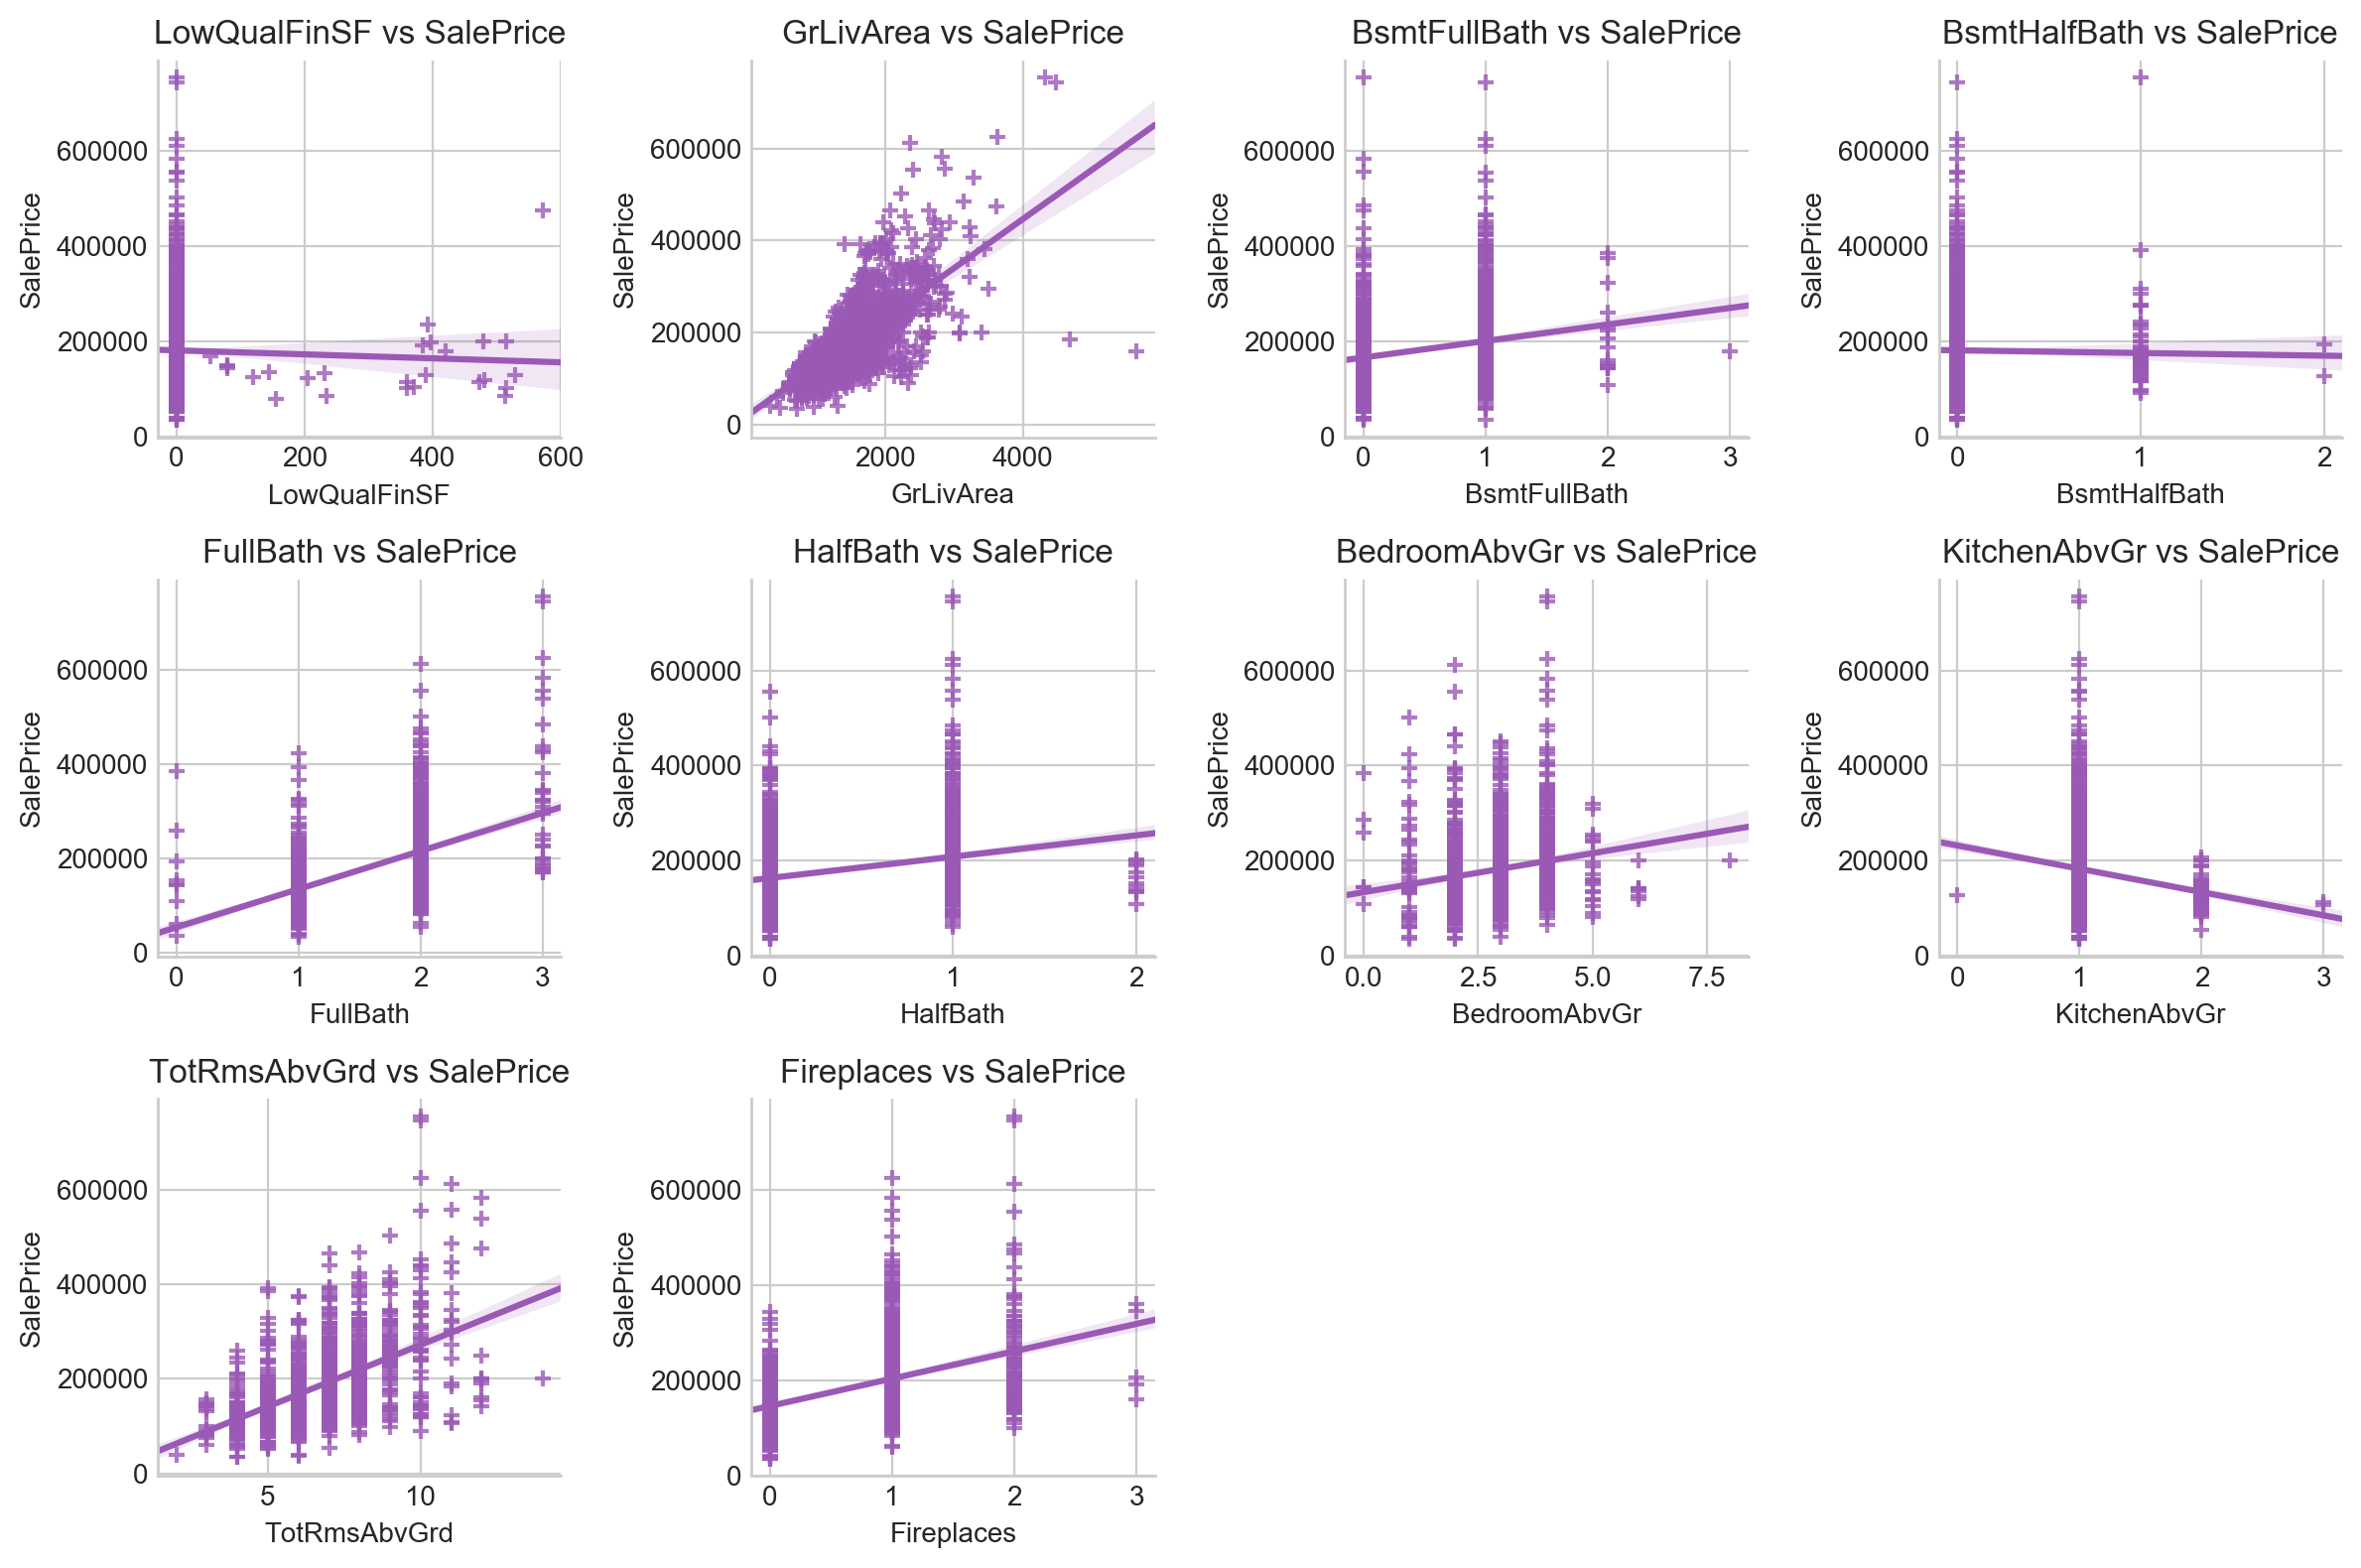

In [18]:
plot_dataset(X_train,continuous_features[10:20],RESPONSE,log=False)

#### Inferences
###### OverallQual,OverallCond  are ordinal columns
###### BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars have minimum value as  zero - Need to verify
###### GrLivArea has linear relation with SalePrice. However  these values need to be log transformed  to re-evaluvate


In [19]:
X_train[continuous_features].iloc[:,20:].head()

GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal
0           2         548           0           61              0          0            0         0        0
1           2         460         298            0              0          0            0         0        0
2           2         608           0           42              0          0            0         0        0
3           3         642           0           35            272          0            0         0        0
4           3         836         192           84              0          0            0         0        0

In [20]:
X_train[continuous_features].iloc[:,20:].describe()

GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch   PoolArea    MiscVal
count   1460.0000   1460.0000   1460.0000    1460.0000      1460.0000  1460.0000    1460.0000  1460.0000   1460.000
mean       1.7671    472.9801     94.2445      46.6603        21.9541     3.4096      15.0610     2.7589     43.489
std        0.7473    213.8048    125.3388      66.2560        61.1191    29.3173      55.7574    40.1773    496.123
min        0.0000      0.0000      0.0000       0.0000         0.0000     0.0000       0.0000     0.0000      0.000
25%        1.0000    334.5000      0.0000       0.0000         0.0000     0.0000       0.0000     0.0000      0.000
50%        2.0000    480.0000      0.0000      25.0000         0.0000     0.0000       0.0000     0.0000      0.000
75%        2.0000    576.0000    168.0000      68.0000         0.0000     0.0000       0.0000     0.0000      0.000
max        4.0000   1418.0000    857.0000     547.0000       552.0000   508.0000     480.0000   738.0000  15500.000

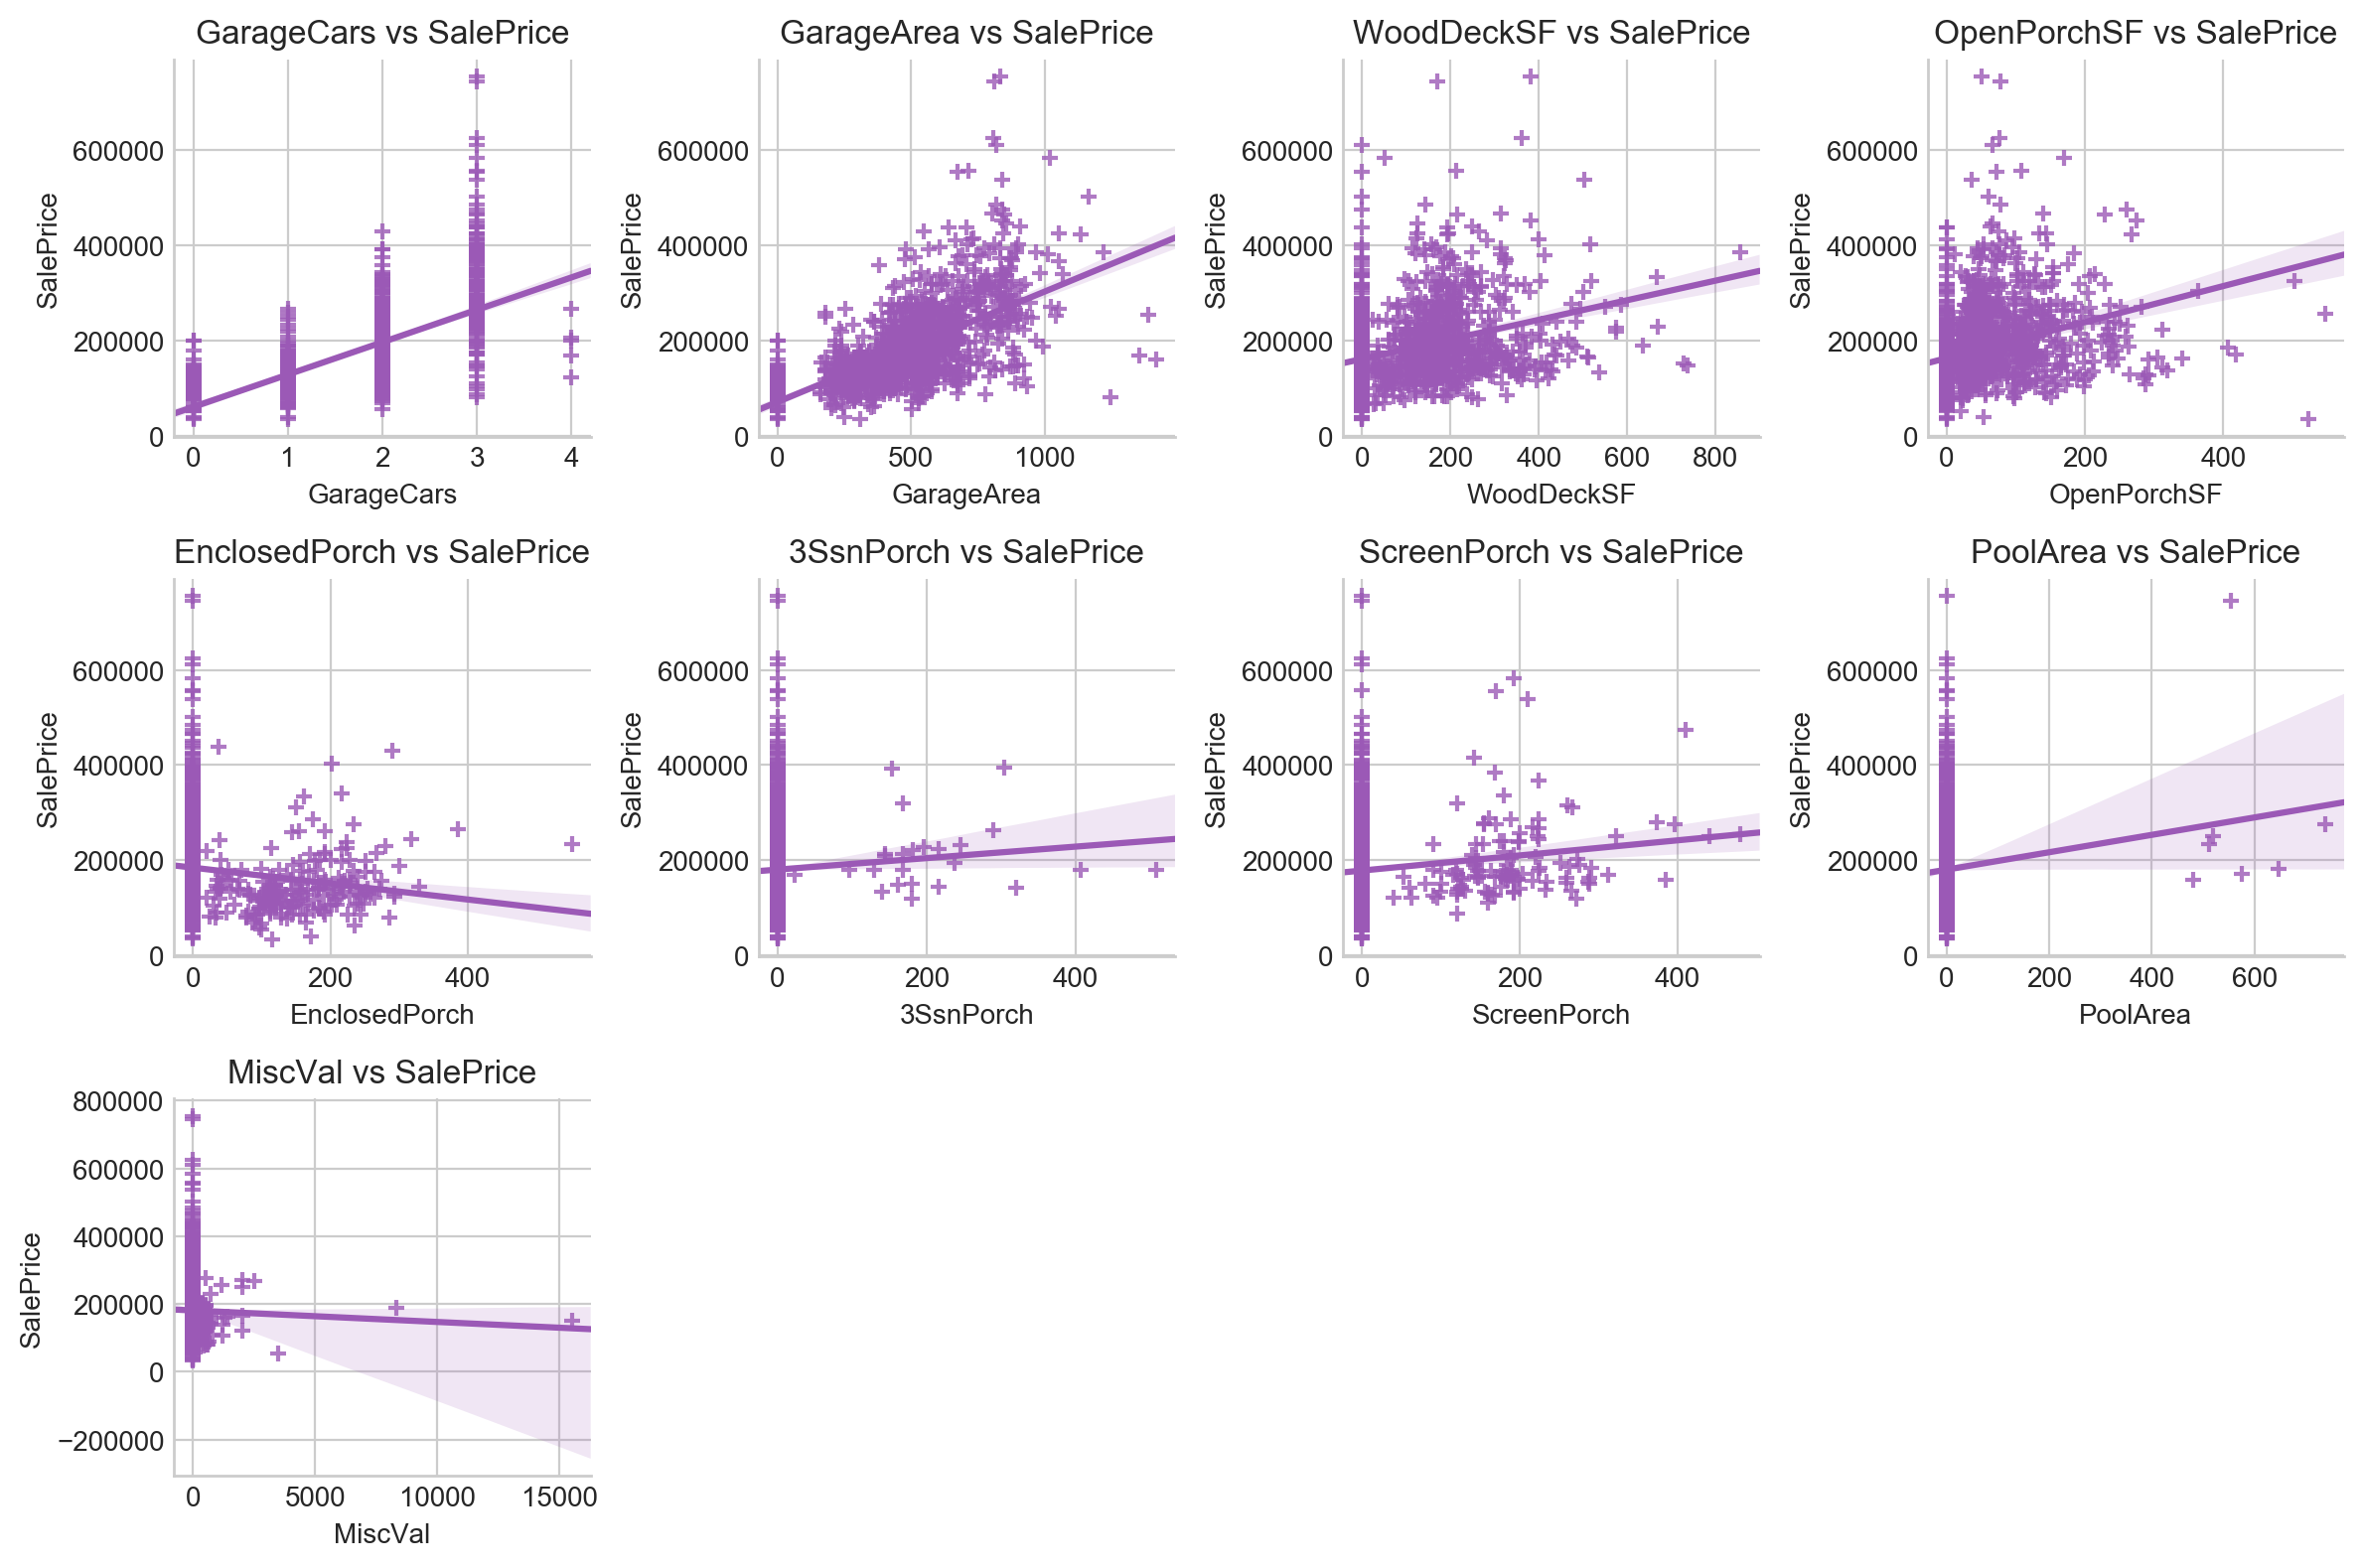

In [21]:
plot_dataset(X_train,continuous_features[20:],RESPONSE,log=False)


#### Inferences
##### GarageArea ,WoodDeckSF has linear relation with SalePrice  However  these values need to be log transformed  to re-evaluvate

In [22]:
#X_train_categorical =train_loader.dataframe[categorical_features]
X_train[categorical_features].head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  MSSubClass  OverallQual  OverallCond  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           No          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ         NaN     Attchd          RFn         TA         TA          Y    NaN   NaN         NaN       WD        Normal          60            7            5   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story     Gable  CompShg     MetalSd     MetalSd       None        TA        TA     CBlock       Gd       TA           Gd          ALQ          Unf    GasA        Ex          Y      SBrkr          TA        Typ          TA     Attchd          RFn         TA         TA          Y    NaN   NaN         NaN       WD        Normal          20            6            8   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           Mn          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ          TA     Attchd          RFn         TA         TA          Y    NaN   NaN         NaN       WD        Normal          60            7            5   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story     Gable  CompShg     Wd Sdng     Wd Shng       None        TA        TA     BrkTil       TA       Gd           No          ALQ          Unf    GasA        Gd          Y      SBrkr          Gd        Typ          Gd     Detchd          Unf         TA         TA          Y    NaN   NaN         NaN       WD       Abnorml          70            7            5   
4       RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           Av          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ          TA     Attchd          RFn         TA         TA          Y    NaN   NaN         NaN       WD        Normal          60            8            5   

   YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold  
0       2003          2003       2003.0       2    2008  
1       1976          1976       1976.0       5    2007  
2       2001          2002       2001.0       9    2008  
3       1915          1970       1998.0       2    2006  
4       2000          2000       2000.0      12    2008

In [23]:
#X_test_categorical =test_loader.dataframe[categorical_features]
X_test[categorical_features].head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  MSSubClass  OverallQual  OverallCond  \
0       RH   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story     Gable  CompShg     VinylSd     VinylSd       None        TA        TA     CBlock       TA       TA           No          Rec          LwQ    GasA        TA          Y      SBrkr          TA        Typ         NaN     Attchd          Unf         TA         TA          Y    NaN  MnPrv         NaN       WD        Normal          20            5            6   
1       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace        TA        TA     CBlock       TA       TA           No          ALQ          Unf    GasA        TA          Y      SBrkr          Gd        Typ         NaN     Attchd          Unf         TA         TA          Y    NaN    NaN        Gar2       WD        Normal          20            6            6   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd       None        TA        TA      PConc       Gd       TA           No          GLQ          Unf    GasA        Gd          Y      SBrkr          TA        Typ          TA     Attchd          Fin         TA         TA          Y    NaN  MnPrv         NaN       WD        Normal          60            5            5   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        TA        TA      PConc       TA       TA           No          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ          Gd     Attchd          Fin         TA         TA          Y    NaN    NaN         NaN       WD        Normal          60            6            6   
4       RL   Pave   NaN      IR1         HLS    AllPub    Inside       Gtl      StoneBr       Norm       Norm   TwnhsE     1Story     Gable  CompShg     HdBoard     HdBoard       None        Gd        TA      PConc       Gd       TA           No          ALQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ         NaN     Attchd          RFn         TA         TA          Y    NaN    NaN         NaN       WD        Normal         120            8            5   

   YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold  
0       1961          1961       1961.0       6    2010  
1       1958          1958       1958.0       6    2010  
2       1997          1998       1997.0       3    2010  
3       1998          1998       1998.0       6    2010  
4       1992          1992       1992.0       1    2010

In [24]:
check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageQual        81
GarageFinish      81
GarageType        81
GarageCond        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64
<=================================== Dataset null value count ===================================>
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MSZoning           4
Utilities          2
Functional         2
SaleType           1
Exterior2nd 

##### Categorical features  having "NA"  need not be considered as missing values.


In [25]:
## 'MasVnrType' NA - is same as None

NA_mapping ={'PoolQC':'No Pool','MiscFeature':'No MiscFeature','Alley':'No Alley',
'Fence':'No Fence','FireplaceQu':'No Fireplace ','GarageYrBlt':-1,
'GarageCond':'No Garage','GarageQual':'No Garage','GarageFinish':'No Garage',
'GarageType':'No Garage','BsmtCond':'No Basement','BsmtQual':'No Basement',
'BsmtExposure':'No Basement','BsmtFinType2':'No Basement','BsmtFinType1':'No Basement' ,
'MasVnrType':'None'
}

for feature in NA_mapping.keys():
    default_value  = NA_mapping.get(feature)
    X_train[feature].fillna(default_value,inplace = True)
    X_test[feature].fillna(default_value,inplace = True)
    
        

In [26]:
check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
Electrical    1
dtype: int64
<=================================== Dataset null value count ===================================>
MSZoning       4
Functional     2
Utilities      2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
dtype: int64


In [27]:
X_train[X_train['Electrical'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
1379  1380          80       RL         73.0     9735   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl       Timber       Norm       Norm     1Fam       SLvl            5            5       2006          2007     Gable  CompShg     VinylSd     VinylSd       None         0.0        TA        TA      PConc       Gd       TA           No          Unf           0          Unf           0        384          384    GasA        Gd          Y        NaN       754       640   

      LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   PoolQC     Fence     MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice  
1379             0       1394             0             0         2         1             3             1          Gd             7        Typ           0  No Fireplace     BuiltIn       2007.0          Fin           2         400         TA         TA          Y         100            0              0          0            0         0  No Pool  No Fence  No MiscFeature        0       5    2008       WD        Normal     167500

In [28]:
X_test[X_test['MSZoning'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
455   1916          30      NaN        109.0    21780   Grvl  No Alley      Reg         Lvl       NaN    Inside       Gtl       IDOTRR       Norm       Norm     1Fam     1Story            2            4       1910          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None         0.0        Fa        Fa     CBlock  No Basement  No Basement  No Basement  No Basement         0.0  No Basement         0.0        0.0          0.0    GasA        TA          N      FuseA       810         0   
756   2217          20      NaN         80.0    14584   Pave  No Alley      Reg         Low    AllPub    Inside       Mod       IDOTRR       Norm       Norm     1Fam     1Story            1            5       1952          1952     Gable  CompShg     AsbShng     VinylSd       None         0.0        Fa        Po       Slab  No Basement  No Basement  No Basement  No Basement         0.0  No Basement         0.0        0.0          0.0    Wall        Po          N      FuseA       733         0   
790   2251          70      NaN          NaN    56600   Pave  No Alley      IR1         Low    AllPub    Inside       Gtl       IDOTRR       Norm       Norm     1Fam     2.5Unf            5            1       1900          1950       Hip  CompShg     Wd Sdng     Wd Sdng       None         0.0        TA        TA     BrkTil           TA           TA           No          Unf         0.0          Unf         0.0      686.0        686.0    GasA        Ex          Y      SBrkr      1150       686   
1444  2905          20      NaN        125.0    31250   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl      Mitchel     Artery       Norm     1Fam     1Story            1            3       1951          1951     Gable  CompShg      CBlock     VinylSd       None         0.0        TA        Fa     CBlock  No Basement  No Basement  No Basement  No Basement         0.0  No Basement         0.0        0.0          0.0    GasA        TA          Y      FuseA      1600         0   

      LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   PoolQC     Fence     MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  
455              0        810           0.0           0.0         1         0             1             1          TA             4       Min1           0  No Fireplace      Detchd       1975.0          Unf         1.0       280.0         TA         TA          N         119           24              0          0            0         0  No Pool  No Fence  No MiscFeature        0       3    2009    ConLD        Normal  
756              0        733           0.0           0.0         1         0             2             1          Fa             4        NaN           0  No Fireplace      Attchd       1952.0          Unf         2.0       487.0         Fa         Po          N           0            0              0          0            0         0  No Pool  No Fence  No MiscFeature        0       2    2008       WD       Abnorml  
790              0       1836           0.0           0.0         2         0             4             1          TA             7       Maj1           0  No Fireplace      Detchd       1900.0          Unf         1.0       288.0   

In [29]:
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts()) 
X_train['Neighborhood'].fillna('RM',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts())
X_train['Neighborhood'].fillna('RM',inplace = True)

### Timber neighborhood has SBrkr as electrical system.
print(X_train[X_train['Neighborhood'] == 'Timber']['Electrical'].value_counts()) 
X_train['Electrical'].fillna('SBrkr',inplace = True)

RM         40
C (all)    13
Name: MSZoning, dtype: int64
RM         28
C (all)     9
Name: MSZoning, dtype: int64
SBrkr    36
FuseA     1
Name: Electrical, dtype: int64


In [30]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
X_test['Functional'].fillna('Typ',inplace = True)
X_test[X_test['Functional'].isnull()]

Typ     35
Mod      1
Maj2     1
Name: Functional, dtype: int64
Typ     44
Min1     3
Min2     3
Mod      2
Maj1     1
Maj2     1
Name: Functional, dtype: int64


Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

In [31]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts())
print(X_train[X_train['Neighborhood'] == 'Gilbert']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'Gilbert']['Utilities'].value_counts())
X_test[X_test['Utilities'].isnull()]
X_test['Utilities'].fillna('AllPub',inplace = True)

AllPub    37
Name: Utilities, dtype: int64
AllPub    55
Name: Utilities, dtype: int64
AllPub    79
Name: Utilities, dtype: int64
AllPub    85
Name: Utilities, dtype: int64


In [32]:
X_test[X_test['SaleType'].isnull()]
print(X_test[X_test['Neighborhood'] == 'Sawyer']['SaleType'].value_counts())
X_test['SaleType'].fillna('WD',inplace = True)

WD     72
COD     3
Oth     1
Name: SaleType, dtype: int64


In [33]:
X_test[X_test['KitchenQual'].isnull()]
print(X_test[X_test['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
print(X_train[X_train['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
X_test['KitchenQual'].fillna('TA',inplace = True)

TA    10
Gd     5
Name: KitchenQual, dtype: int64
TA    14
Gd    12
Ex     2
Name: KitchenQual, dtype: int64


In [34]:
X_test[ (X_test['Neighborhood'] == 'Edwards') & 
                    (X_test['RoofStyle'] == 'Flat') ][ ['Exterior1st','Exterior2nd']]

Exterior1st Exterior2nd
691          NaN         NaN
1399     Plywood     Wd Shng

In [35]:
X_train[ (X_train['Neighborhood'] == 'Edwards') & 
                    (X_train['RoofStyle'] == 'Flat')&
                    (X_train['HouseStyle'] == '1Story')][ ['Exterior1st','Exterior2nd']]

Exterior1st Exterior2nd
1000     BrkComm     Brk Cmn

In [36]:
X_test[X_test['Exterior1st'].isnull()]
X_test['Exterior1st'].fillna('BrkComm',inplace = True)
X_test['Exterior2nd'].fillna('Brk Cmn',inplace = True)

In [37]:
X_test_categorical[X_test_categorical['MSZoning'].isnull()]

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition
455       NaN   Grvl   NaN      Reg         Lvl       NaN    Inside       Gtl       IDOTRR       Norm       Norm     1Fam     1Story     Gable  CompShg     Wd Sdng     Wd Sdng       None        Fa        Fa     CBlock      NaN      NaN          NaN          NaN          NaN    GasA        TA          N      FuseA          TA       Min1         NaN     Detchd          Unf         TA         TA          N    NaN   NaN         NaN    ConLD        Normal
756       NaN   Pave   NaN      Reg         Low    AllPub    Inside       Mod       IDOTRR       Norm       Norm     1Fam     1Story     Gable  CompShg     AsbShng     VinylSd       None        Fa        Po       Slab      NaN      NaN          NaN          NaN          NaN    Wall        Po          N      FuseA          Fa        NaN         NaN     Attchd          Unf         Fa         Po          N    NaN   NaN         NaN       WD       Abnorml
790       NaN   Pave   NaN      IR1         Low    AllPub    Inside       Gtl       IDOTRR       Norm       Norm     1Fam     2.5Unf       Hip  CompShg     Wd Sdng     Wd Sdng       None        TA        TA     BrkTil       TA       TA           No          Unf          Unf    GasA        Ex          Y      SBrkr          TA       Maj1         NaN     Detchd          Unf         TA         Fa          N    NaN   NaN         NaN       WD        Normal
1444      NaN   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      Mitchel     Artery       Norm     1Fam     1Story     Gable  CompShg      CBlock     VinylSd       None        TA        Fa     CBlock      NaN      NaN          NaN          NaN          NaN    GasA        TA          Y      FuseA          TA        Mod         NaN     Attchd          Unf         Fa         TA          N    NaN   NaN         NaN       WD        Normal

In [38]:
### considered neighborhood ,MSSubClass
X_test.loc[455,'MSZoning'] = 'RM'
X_test.loc[756,'MSZoning'] = 'C (all)'
X_test.loc[790,'MSZoning'] = 'RM'
X_test.loc[1444,'MSZoning'] = 'RL'

In [39]:
check_null(X_train)
check_null(X_test)

<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


In [40]:
full_dataset =pd.concat(objs=[X_train, X_test], axis=0).reset_index(drop=True)  

In [41]:
groupby_n= full_dataset.groupby(['Neighborhood'])['LotFrontage'].median()
 

In [42]:
groupby_nls= full_dataset.groupby(['Neighborhood','LotConfig'])['LotFrontage'].median()
groupby_nls[~groupby_nls.isnull()]

Neighborhood  LotConfig
Blmngtn       Inside        43.0
Blueste       CulDSac       24.0
              Inside        24.0
BrDale        Inside        21.0
BrkSide       Corner        51.0
              FR2           60.0
              FR3           79.5
              Inside        51.0
ClearCr       Corner        97.0
              CulDSac       77.5
              Inside        80.0
CollgCr       Corner        89.5
              CulDSac       44.5
              FR2           63.0
              FR3           90.0
              Inside        70.0
Crawfor       Corner        57.5
              CulDSac       63.0
              FR2           69.5
              Inside        70.0
Edwards       Corner        74.0
              CulDSac       38.0
              FR2           60.0
              Inside        62.5
Gilbert       Corner        99.0
              CulDSac       50.0
              FR2           63.5
              Inside        63.0
IDOTRR        Corner        60.0
              FR3  

In [43]:
groupby_nls[groupby_nls.isnull()]

Neighborhood  LotConfig
Gilbert       FR3         NaN
NWAmes        FR3         NaN
Name: LotFrontage, dtype: float64

In [44]:
groupby_nls['Gilbert','FR3']

nan

In [45]:
def fill_missing_frontage(row):
    if pd.isnull(row['LotFrontage']):
        median_frontage = groupby_nls[row['Neighborhood'],row['LotConfig']]
        if np.isnan(median_frontage):
            median_frontage = groupby_n[row['Neighborhood']]
        return median_frontage
    else:
        return row['LotFrontage']

full_dataset['LotFrontage']=full_dataset.apply(fill_missing_frontage,axis=1) 

In [46]:
full_dataset['MasVnrArea'].fillna(0,inplace=True)
full_dataset['MasVnrArea'] = np.log1p(full_dataset['MasVnrArea'])
full_dataset['LogSalePrice'] = np.log1p(full_dataset['SalePrice'])

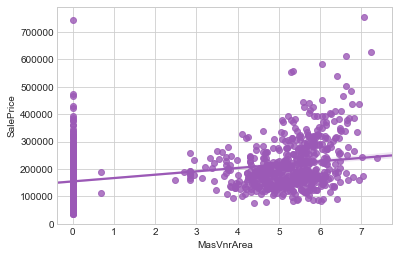

In [47]:
ax = sns.regplot(x="MasVnrArea", y="SalePrice", data=full_dataset[full_dataset['SalePrice'].notnull()])

In [48]:
full_dataset['BsmtHalfBath'].fillna(0,inplace=True)
full_dataset['BsmtFullBath'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtUnfSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF2'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF1'].fillna(0,inplace=True)
full_dataset['GarageArea'].fillna(0,inplace=True)
full_dataset['GarageCars'].fillna(0,inplace=True)

In [49]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
LogSalePrice    1459
SalePrice       1459
dtype: int64


In [50]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset[categorical_features].head()

MSZoning Street     Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional    FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive   PoolQC     Fence     MiscFeature SaleType SaleCondition  MSSubClass  OverallQual  \
0       RL   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           No          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ  No Fireplace      Attchd          RFn         TA         TA          Y  No Pool  No Fence  No MiscFeature       WD        Normal          60            7   
1       RL   Pave  No Alley      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story     Gable  CompShg     MetalSd     MetalSd       None        TA        TA     CBlock       Gd       TA           Gd          ALQ          Unf    GasA        Ex          Y      SBrkr          TA        Typ             TA     Attchd          RFn         TA         TA          Y  No Pool  No Fence  No MiscFeature       WD        Normal          20            6   
2       RL   Pave  No Alley      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           Mn          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ             TA     Attchd          RFn         TA         TA          Y  No Pool  No Fence  No MiscFeature       WD        Normal          60            7   
3       RL   Pave  No Alley      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story     Gable  CompShg     Wd Sdng     Wd Shng       None        TA        TA     BrkTil       TA       Gd           No          ALQ          Unf    GasA        Gd          Y      SBrkr          Gd        Typ             Gd     Detchd          Unf         TA         TA          Y  No Pool  No Fence  No MiscFeature       WD       Abnorml          70            7   
4       RL   Pave  No Alley      IR1         Lvl    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd       TA           Av          GLQ          Unf    GasA        Ex          Y      SBrkr          Gd        Typ             TA     Attchd          RFn         TA         TA          Y  No Pool  No Fence  No MiscFeature       WD        Normal          60            8   

   OverallCond  YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold  
0            5       2003          2003       2003.0       2    2008  
1            8       1976          1976       1976.0       5    2007  
2            5       2001          2002       2001.0       9    2008  
3            5       1915          1970       1998.0       2    2006  
4            5       2000          2000       2000.0      12    2008

In [51]:
print(categorical_features)
ordinal_category.extend(['ExterQual', 'ExterCond','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC',
                         'OverallQual', 'OverallCond','BsmtQual','BsmtCond','BsmtFinType1',
                         'BsmtFinType2' ,'HeatingQC'])
categorical_features = [feature for feature in categorical_features if feature not in ordinal_category ]
len(categorical_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']


31

In [52]:
 
def plot_barplot(dataset,features,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)
    omit_features = ['Neighborhood', 'Condition1', 'Condition2','Exterior1st', 'Exterior2nd']
    features =[feature for feature in features if feature not in omit_features ]
    for i in range(0,len(features)):
        if ((features[i] != response_column ) and (features[i] not in omit_features)):
            ax = fig.add_subplot(3, 4,i + 1)
            sns.barplot(x=features[i], y=response_column, data=train_dataset)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
            if log:
                ax.set(xscale="log",yscale ="log")
            plt.tight_layout()
 
    plt.show()


In [53]:
def plot_boxplot(dataset,features,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)
    omit_features = ['Neighborhood', 'Condition1', 'Condition2','Exterior1st', 'Exterior2nd']
    features =[feature for feature in features if feature not in omit_features ]
    for i in range(0,len(features)):
        if ((features[i] != response_column ) and (features[i] not in omit_features)):
            ax = fig.add_subplot(3, 4,  i + 1)
            if log:
                ax.set(yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.boxplot(x=features[i], y=response_column, data=train_dataset)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
            plt.tight_layout()
 
    plt.show()

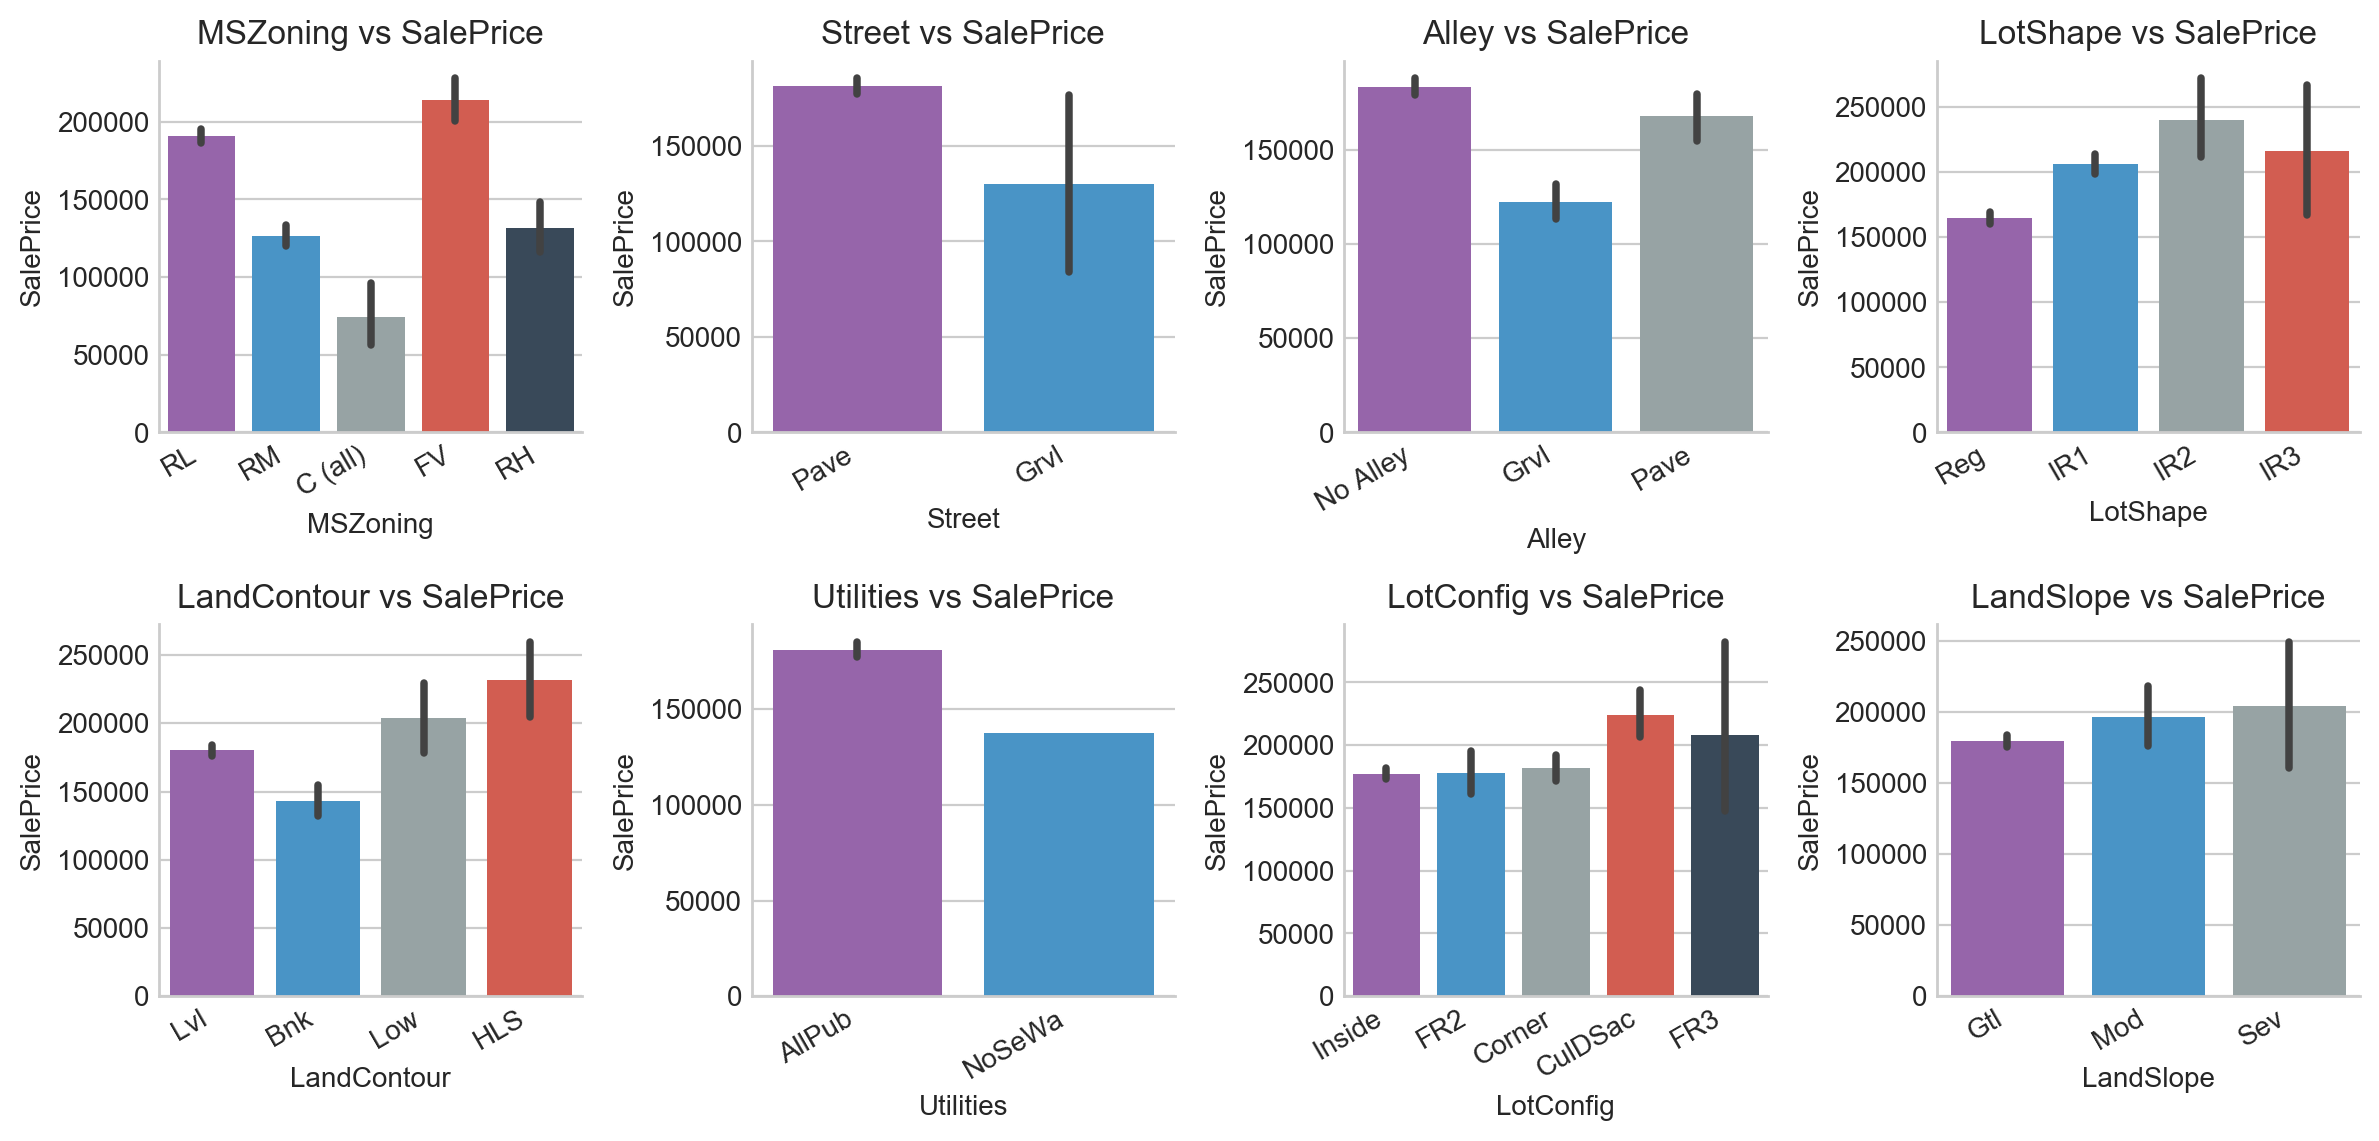

In [54]:
plot_barplot(train_dataset,categorical_features[0:10],"SalePrice",log=False)

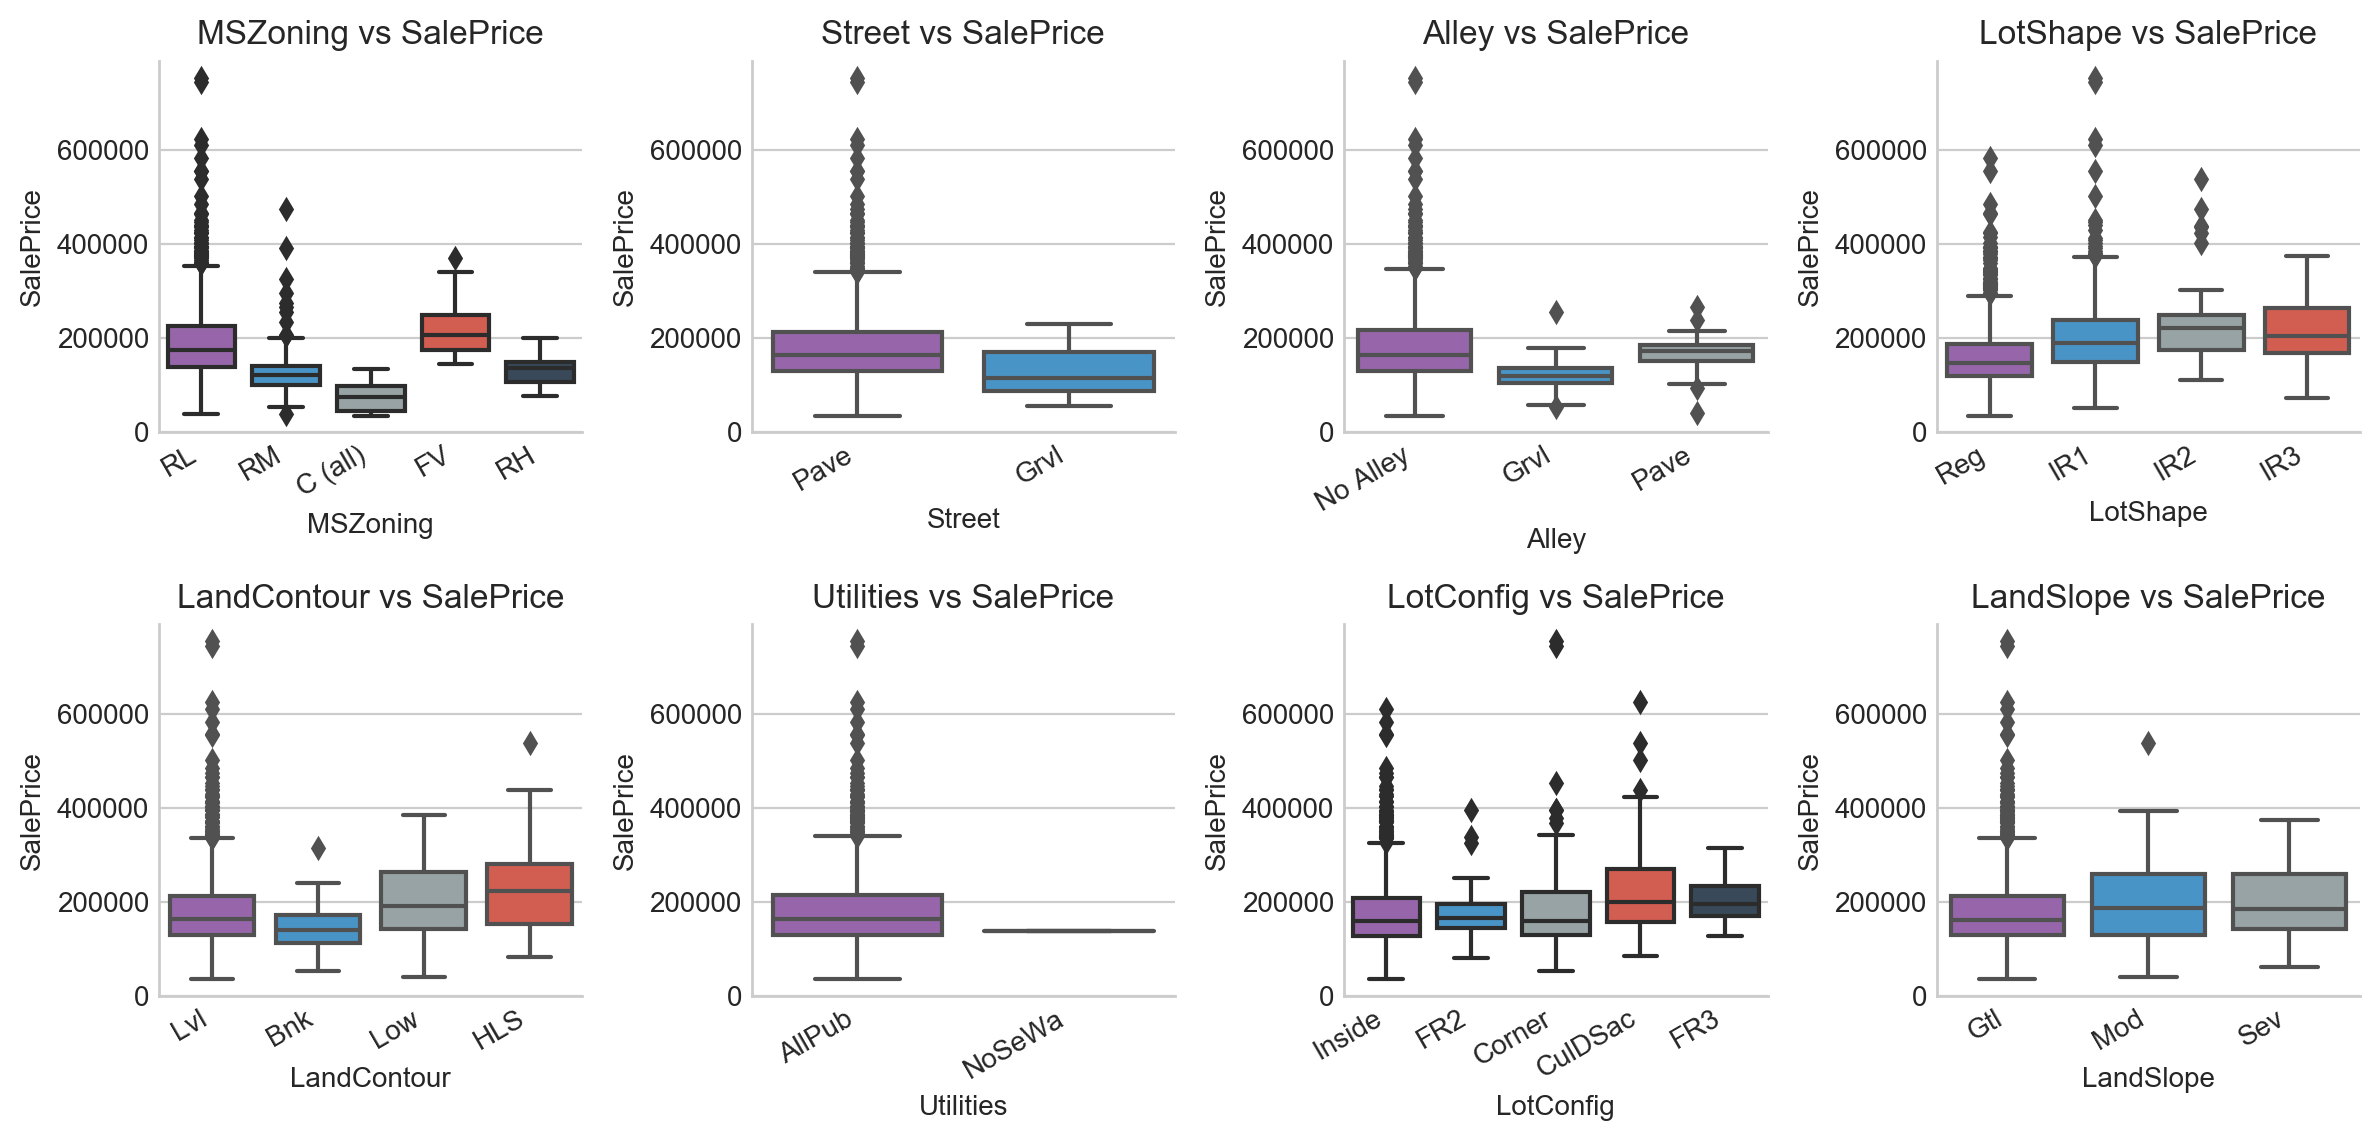

In [55]:
plot_boxplot(train_dataset,categorical_features[0:10],"SalePrice",log=False)

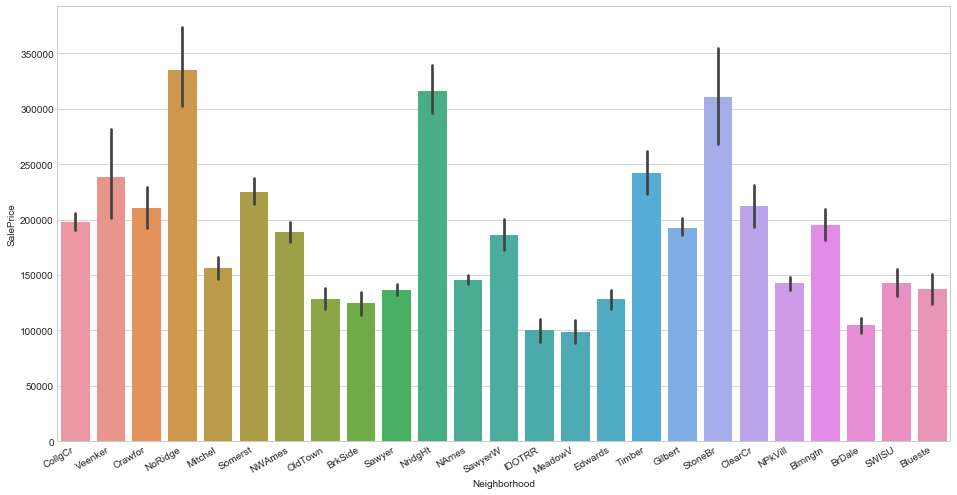

In [56]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.barplot(y="SalePrice", x="Neighborhood", data=train_dataset,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()

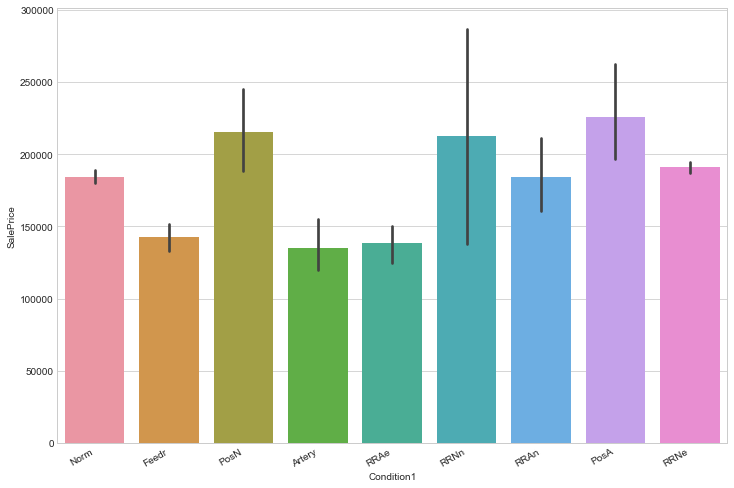

In [57]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.barplot(y="SalePrice", x="Condition1", data=train_dataset,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()

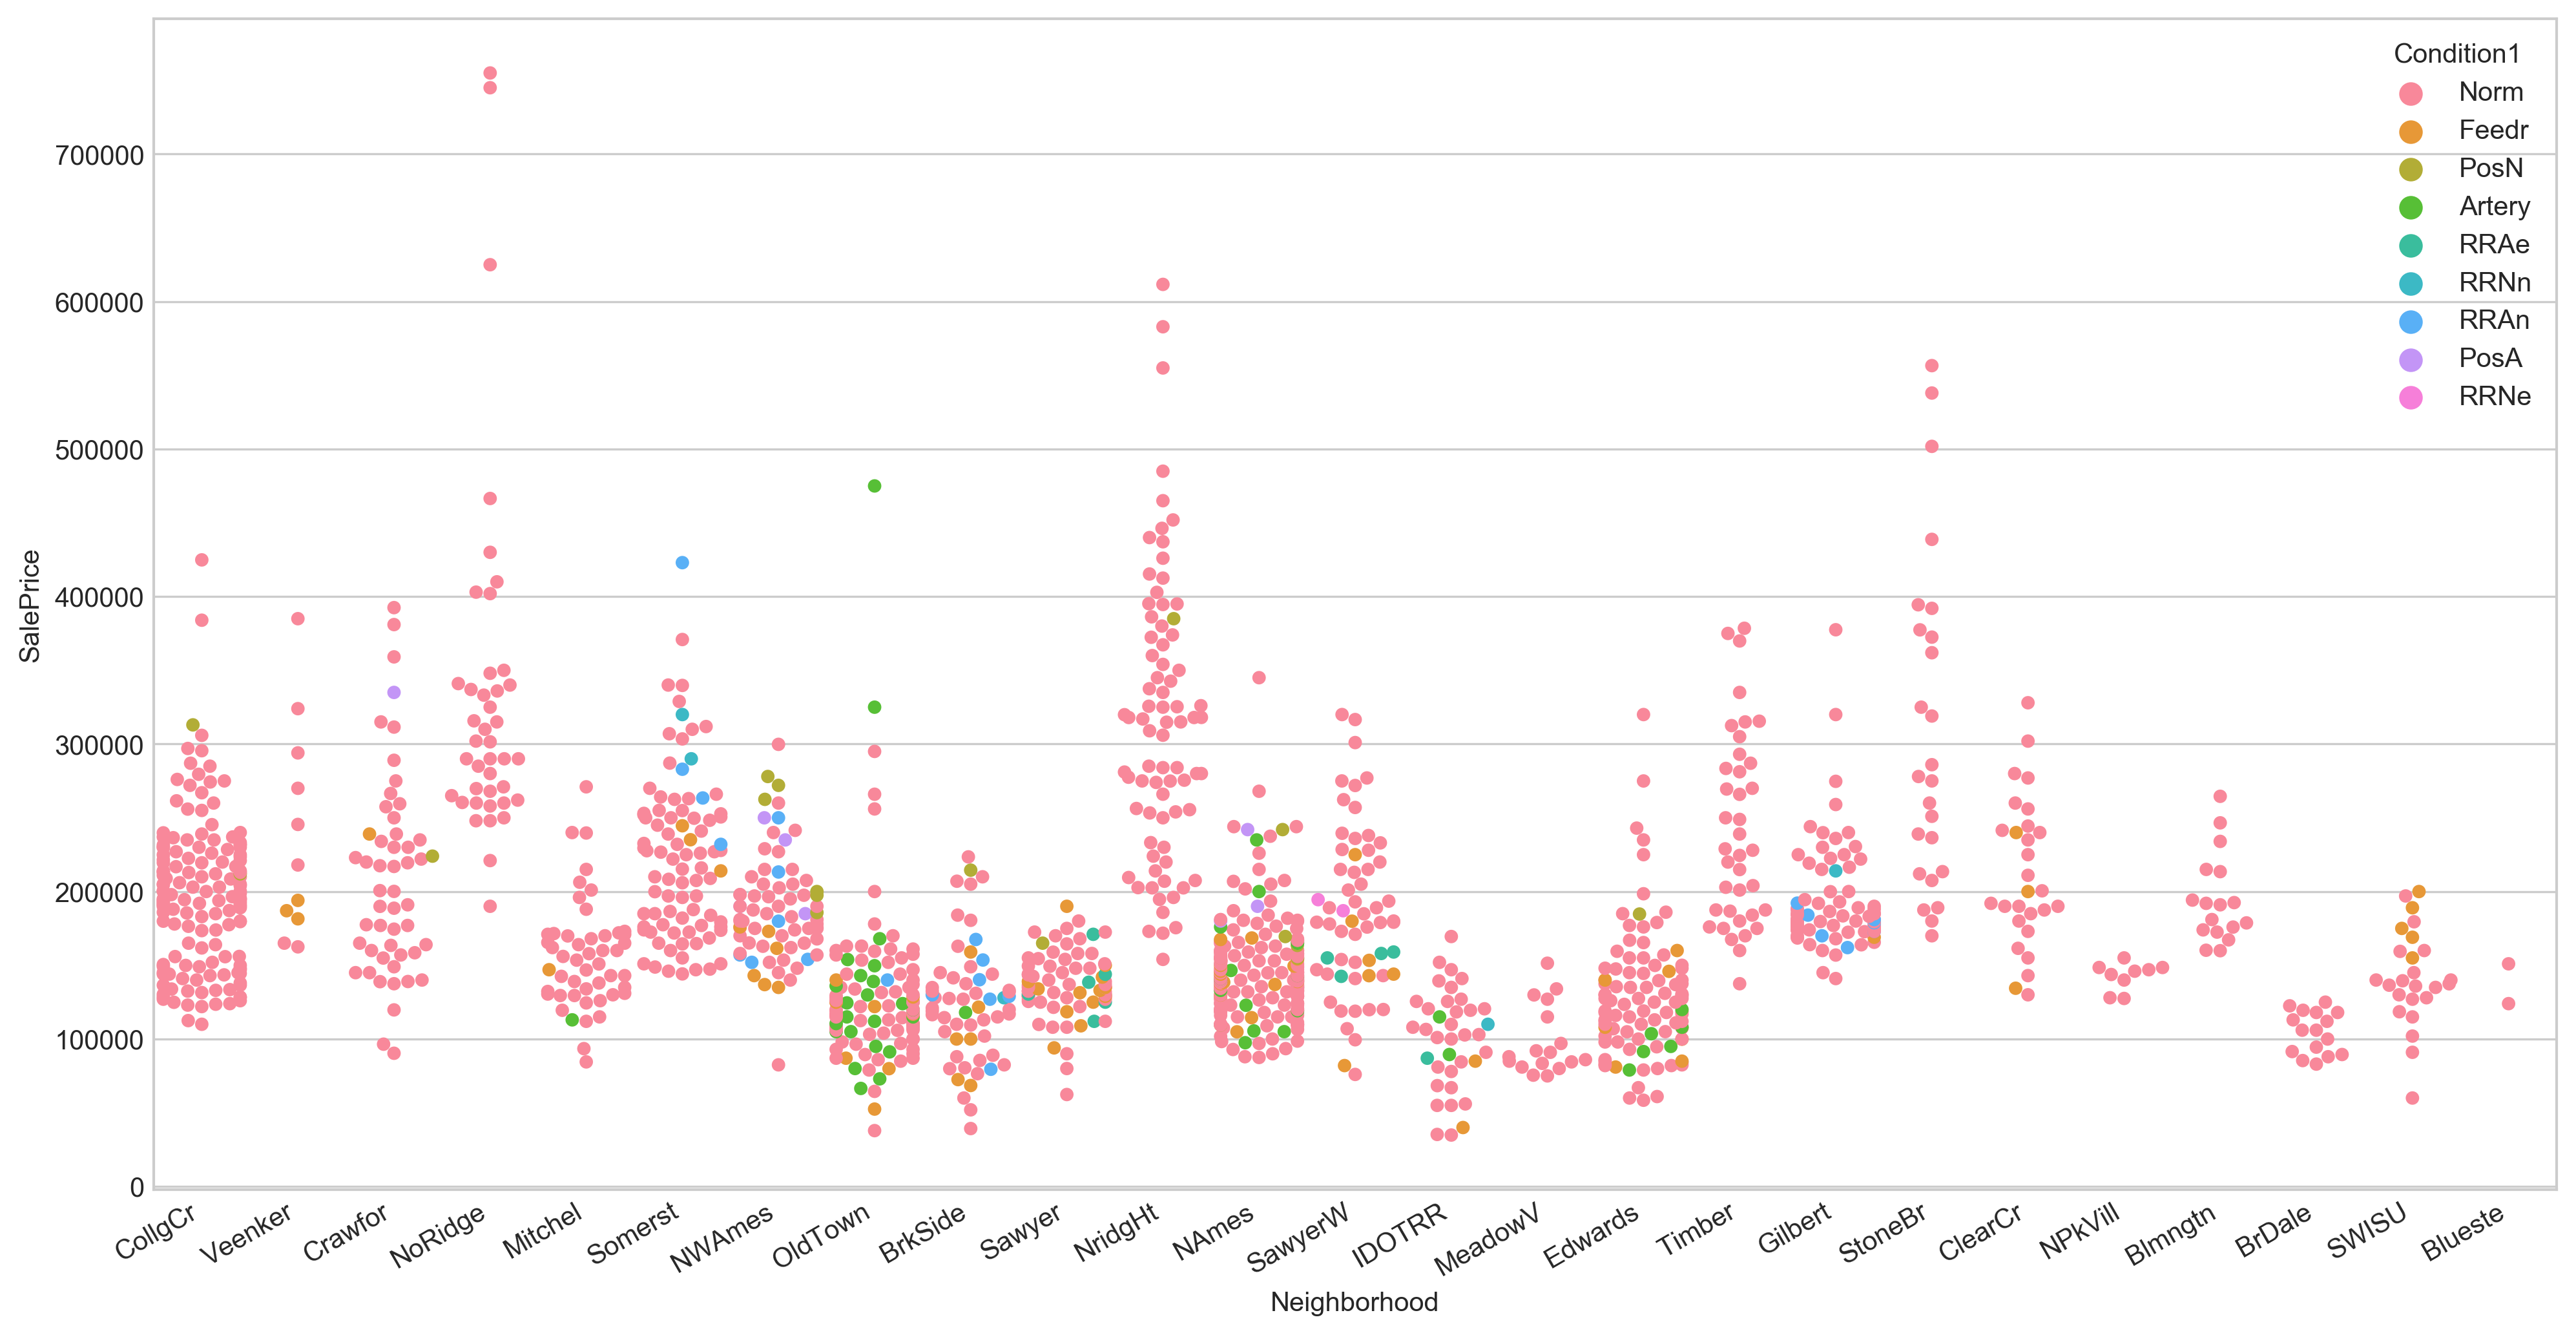

In [58]:
fig = plt.figure(figsize=(16,8),dpi =300)
ax = fig.gca()
sns.swarmplot(y="SalePrice", x="Neighborhood",hue='Condition1',data=train_dataset,ax=ax )
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()
#train_dataset.groupby(['Condition1','Neighborhood'])['SalePrice'].median()

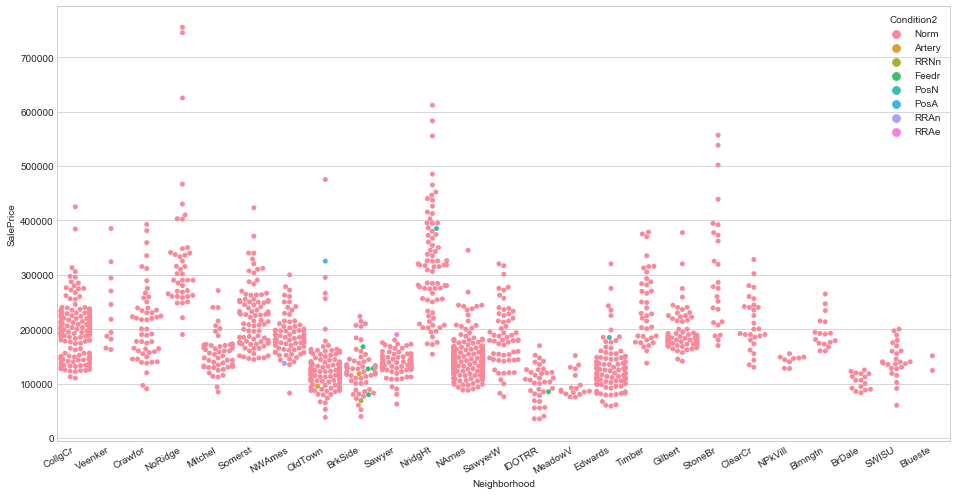

In [59]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.swarmplot(y="SalePrice", x="Neighborhood",hue='Condition2',data=train_dataset,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()

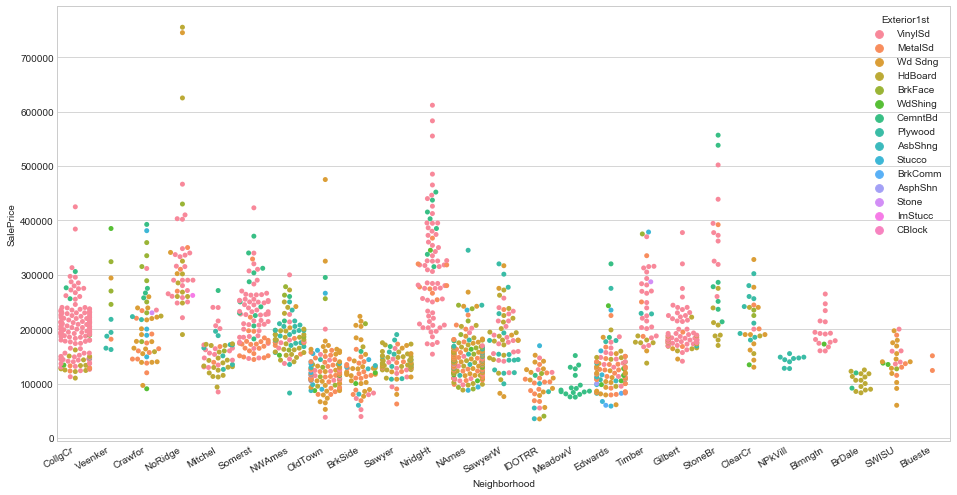

In [60]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.swarmplot(y="SalePrice", x="Neighborhood",hue='Exterior1st',data=train_dataset,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()

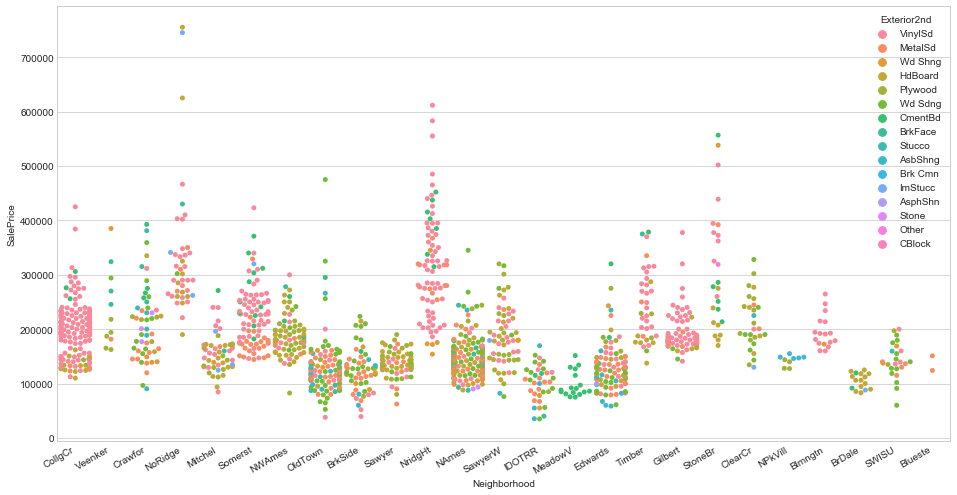

In [61]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.swarmplot(y="SalePrice", x="Neighborhood",hue='Exterior2nd',data=train_dataset,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
plt.show()

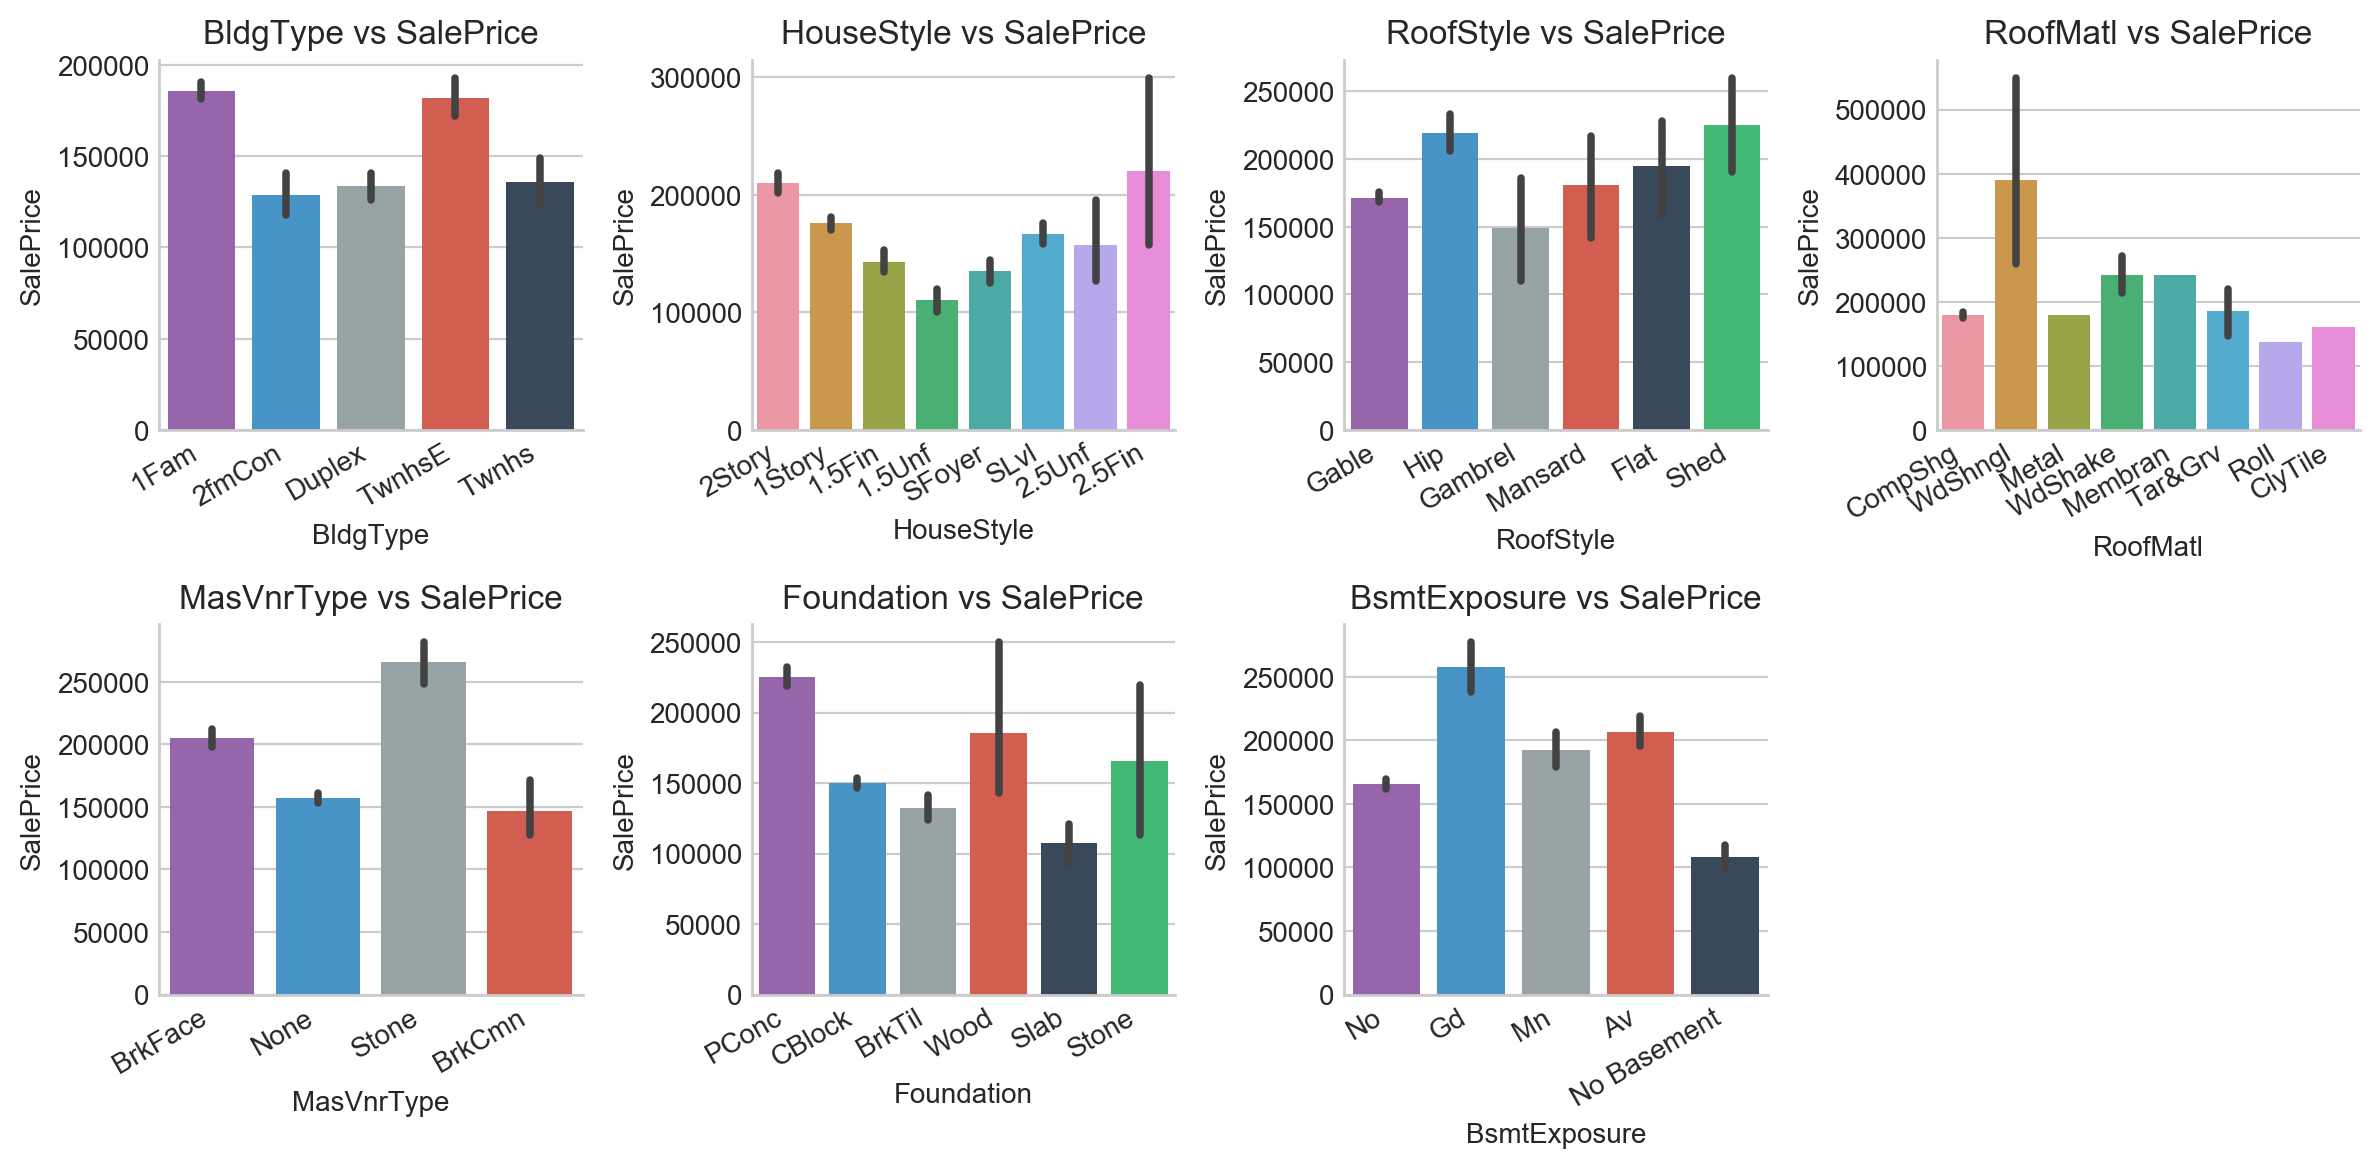

In [62]:
plot_barplot(train_dataset,categorical_features[10:20],"SalePrice",log=False)

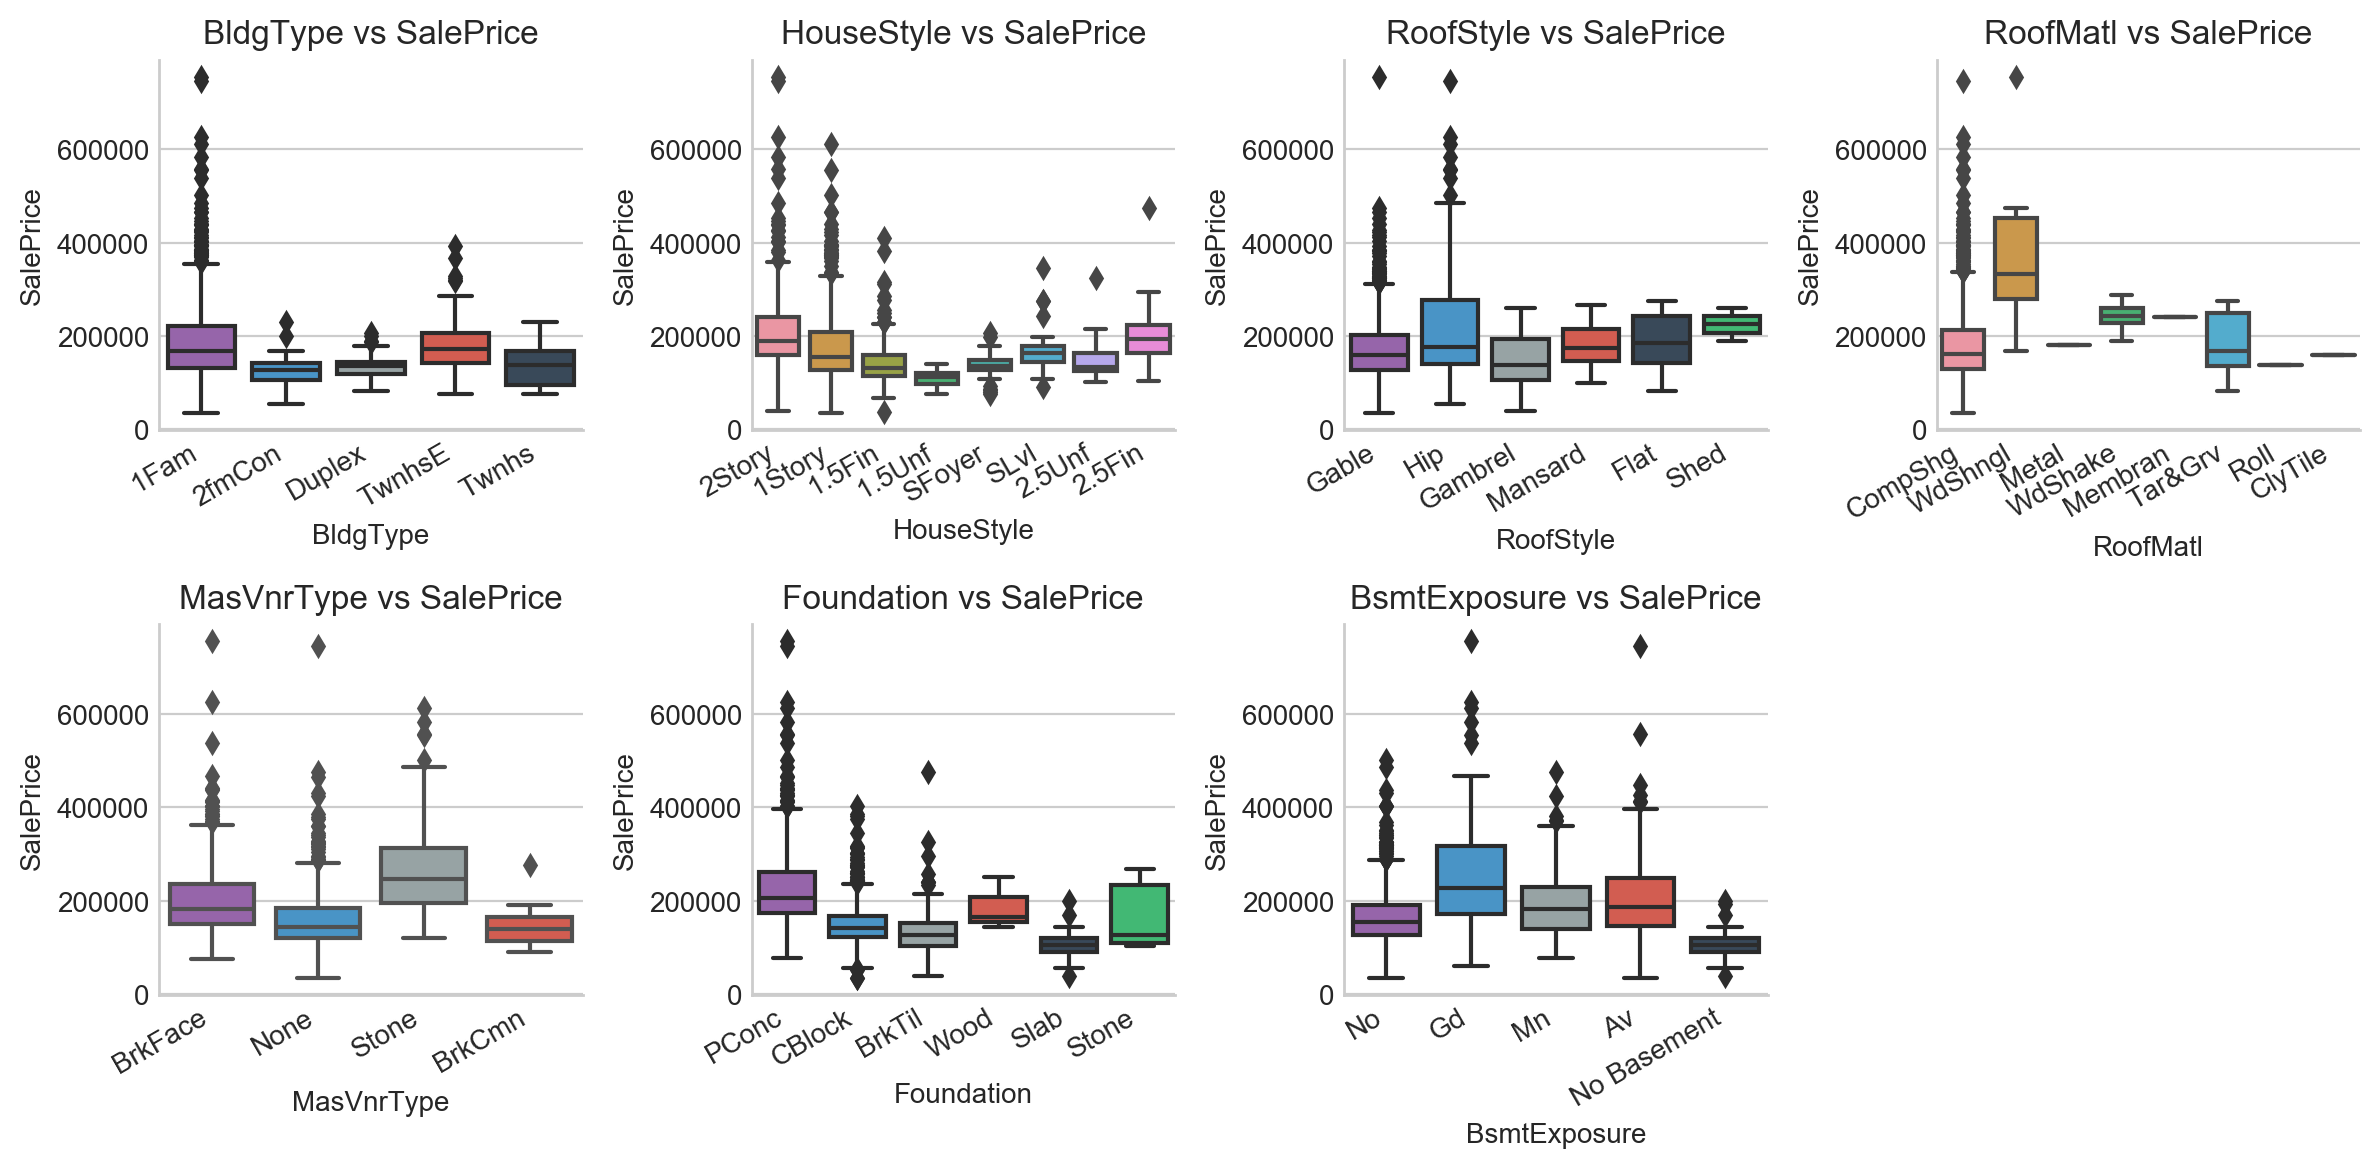

In [63]:
plot_boxplot(train_dataset,categorical_features[10:20],"SalePrice",log=False)

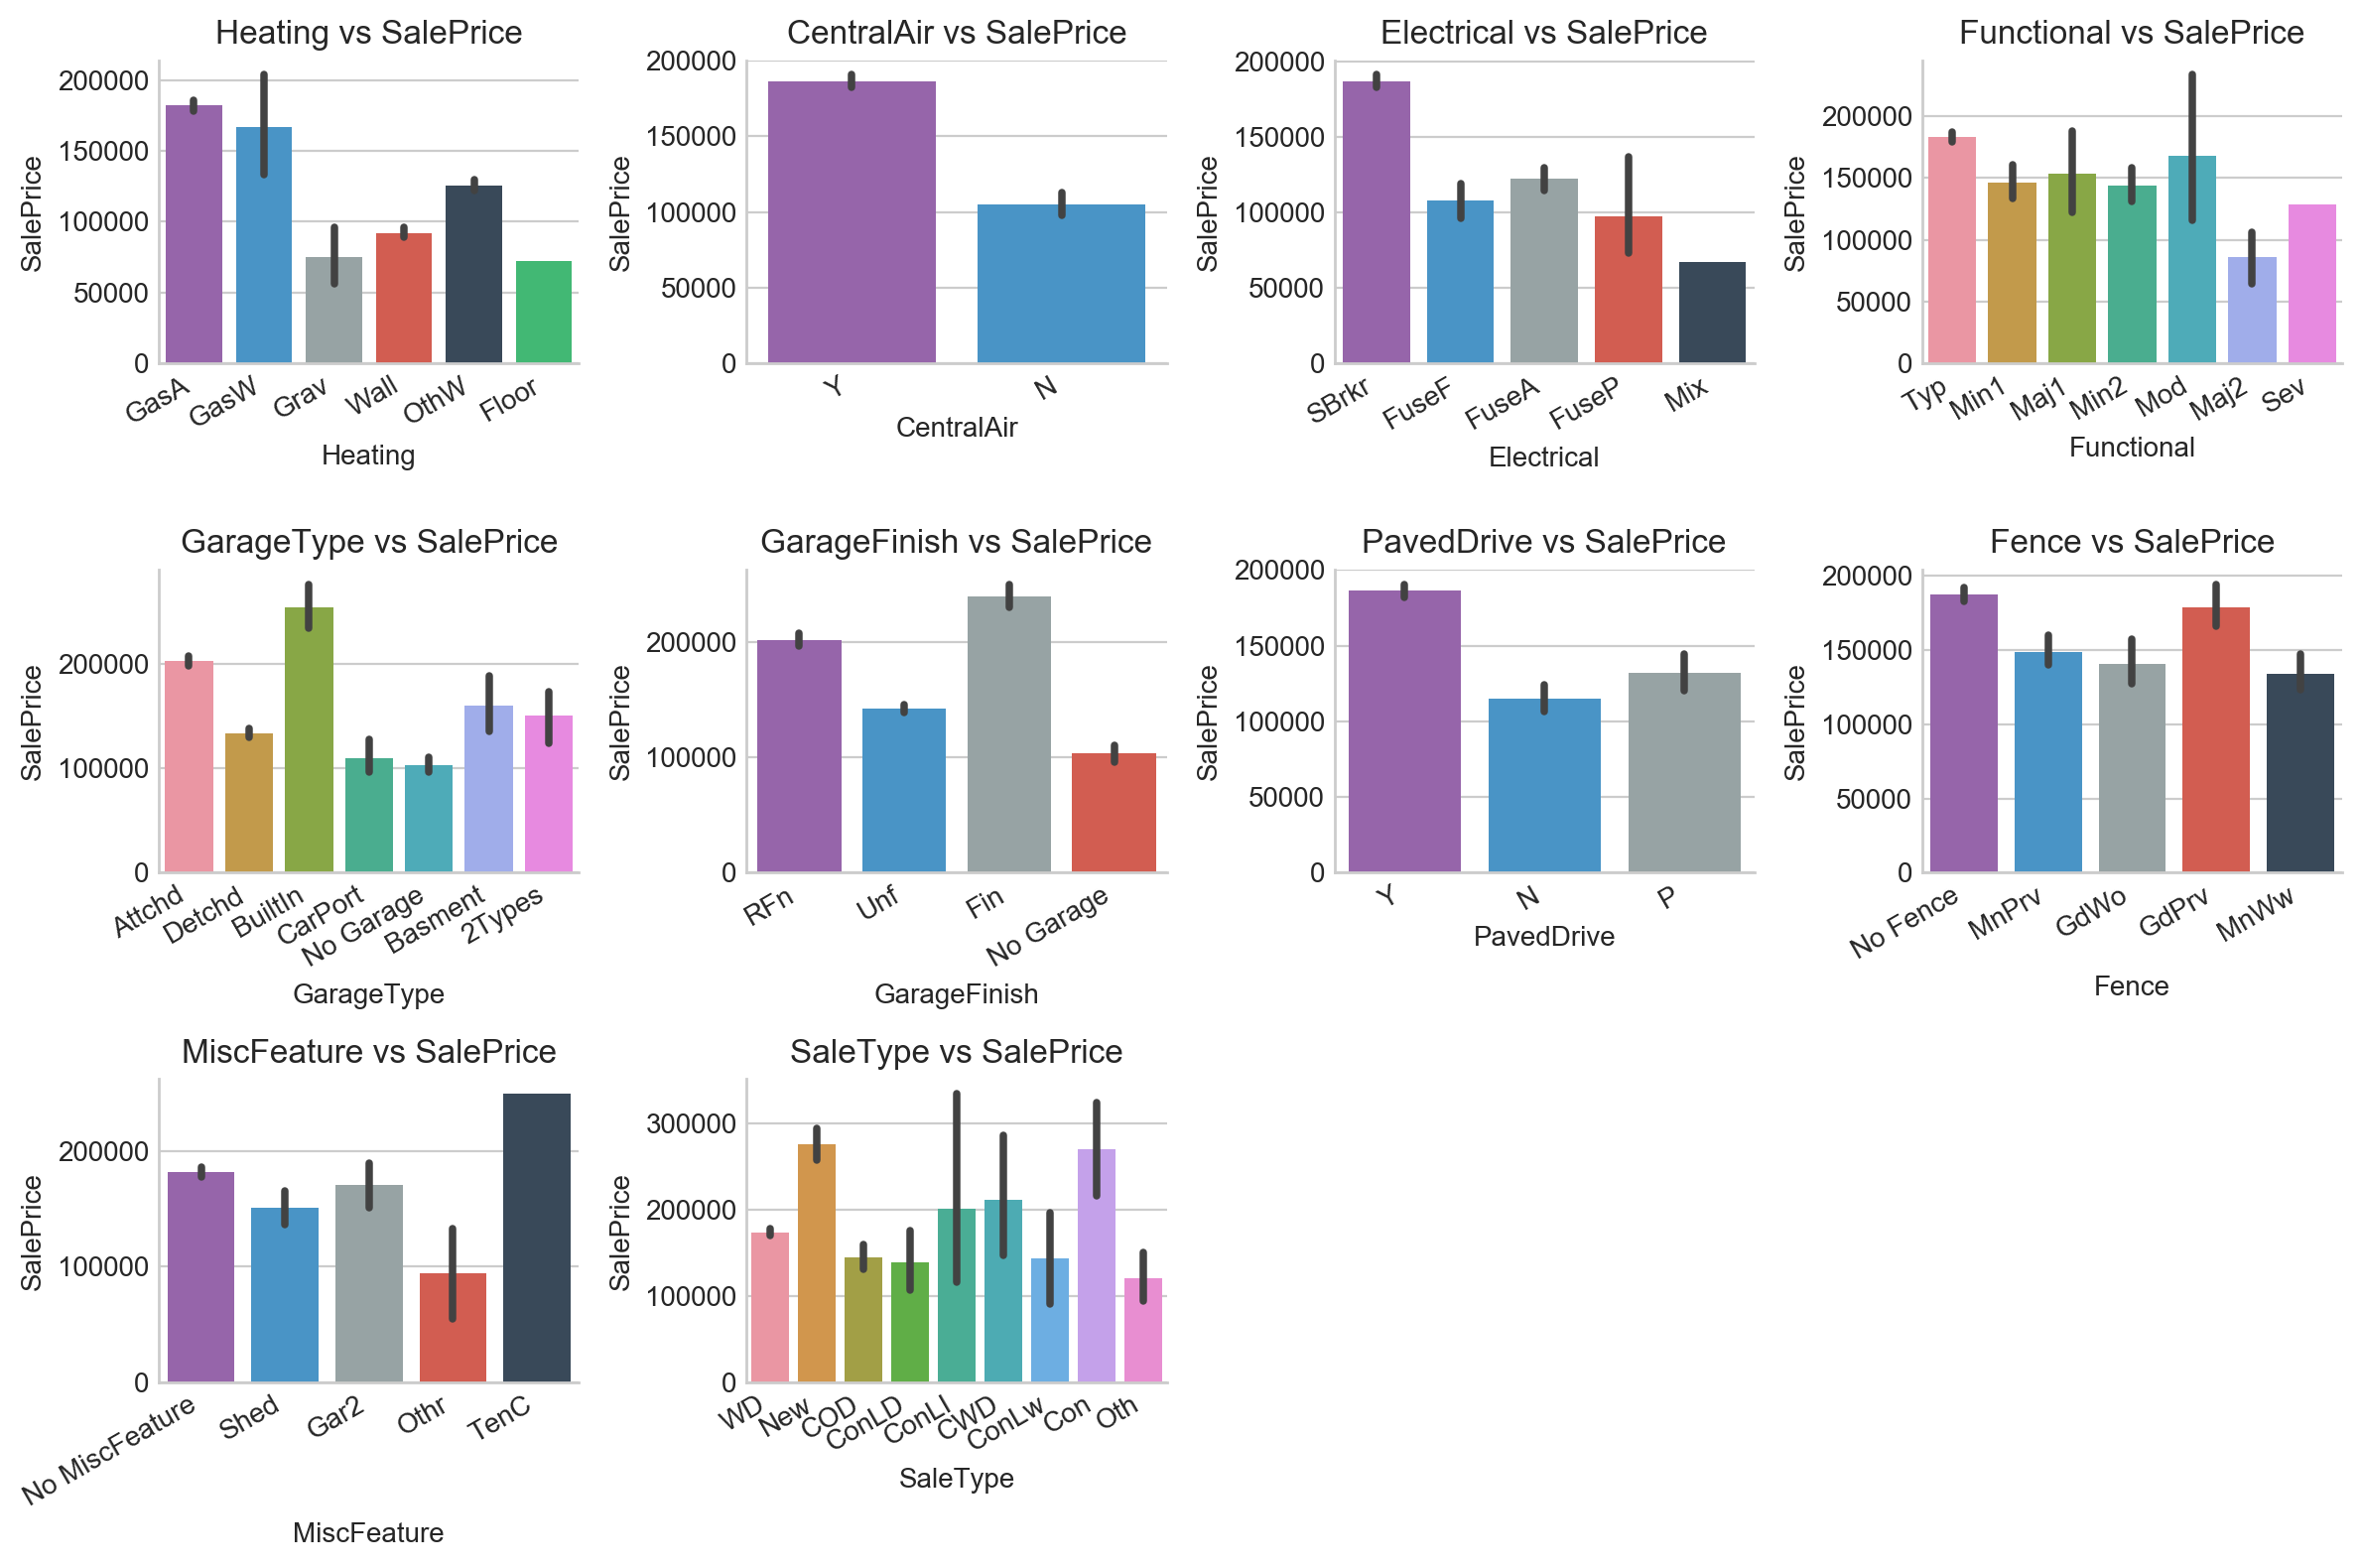

In [64]:
plot_barplot(train_dataset,categorical_features[20:30],"SalePrice",log=False)

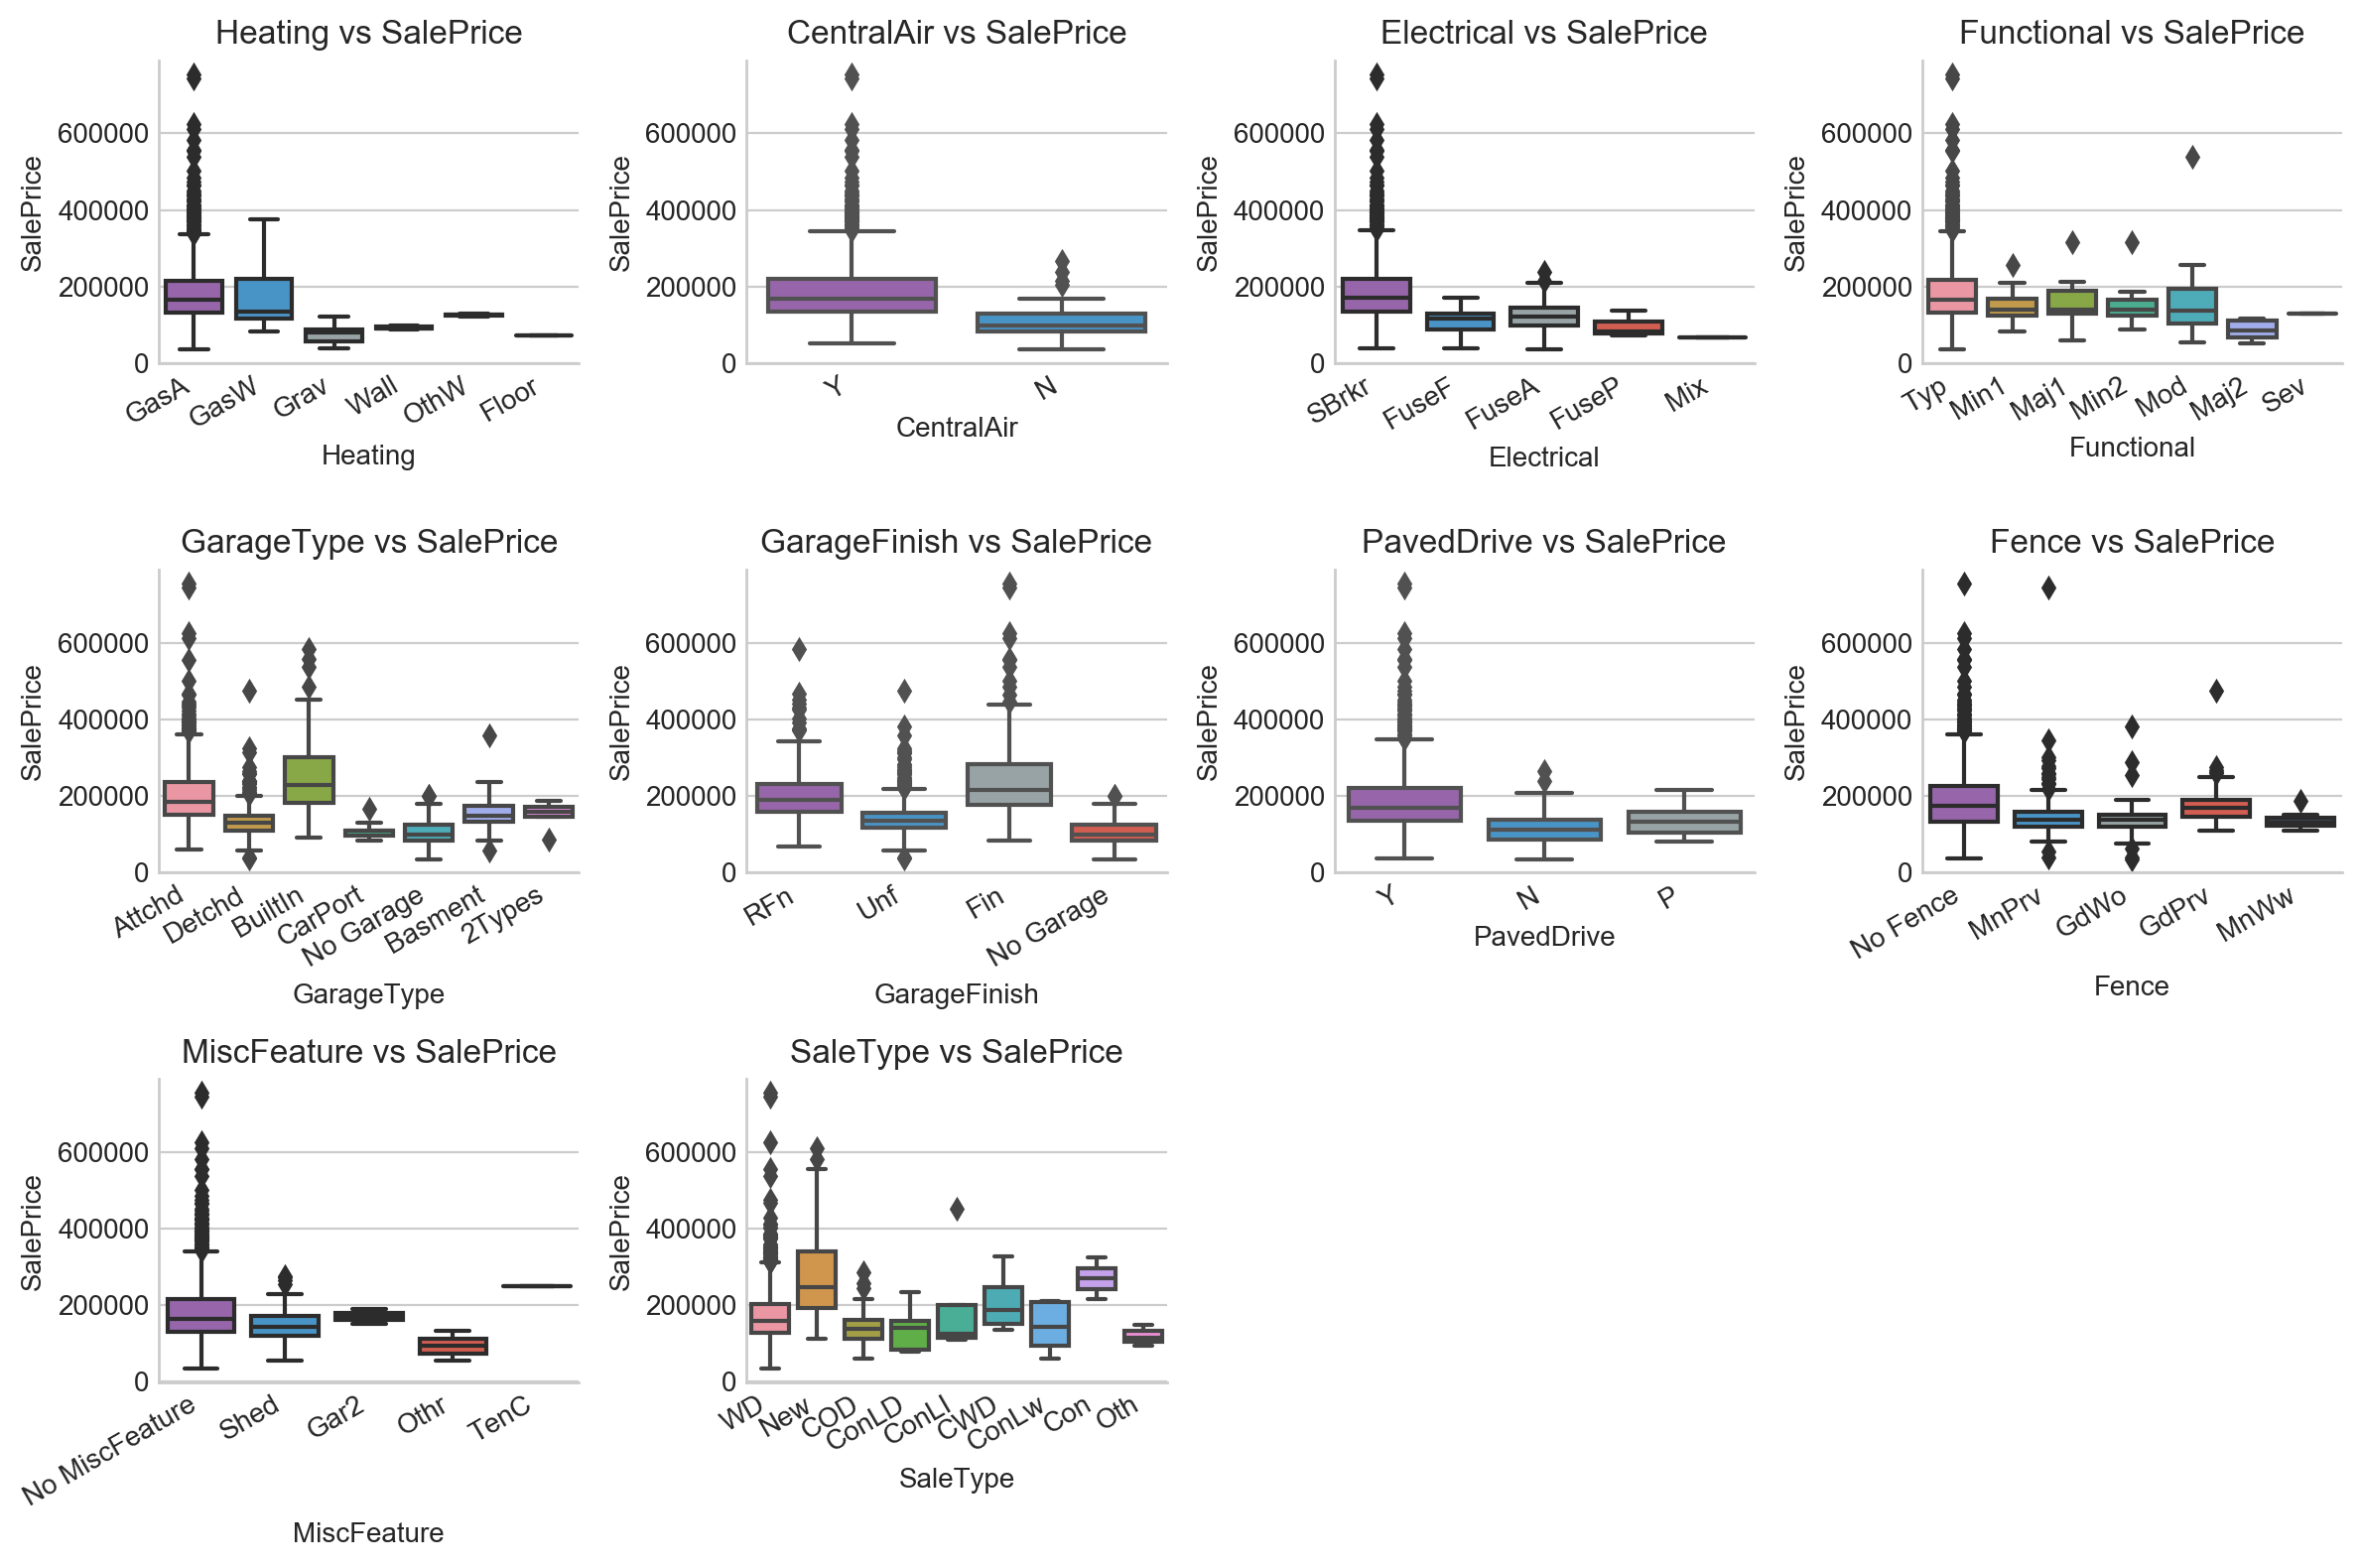

In [65]:
plot_boxplot(train_dataset,categorical_features[20:30],"SalePrice",log=False)

In [66]:
from sklearn.feature_selection import mutual_info_regression
train_features =train_dataset[continuous_features]
train_target = train_dataset[RESPONSE]
scores = mutual_info_regression(train_features, train_target)

df_scores = pd.DataFrame(list(zip(continuous_features,scores)),columns=['features', 'mi_scores'])

mi_scores_median = df_scores['mi_scores'].median()

mi_features = df_scores[df_scores['mi_scores']>= mi_scores_median].sort_values(by=['mi_scores'],ascending=False)
mi_features
#df_scores[df_scores['mi_scores'] < mi_scores_median]
#df.sort_values(by=['col1'])

features  mi_scores
11     GrLivArea     0.4812
20    GarageCars     0.3720
7    TotalBsmtSF     0.3679
21    GarageArea     0.3619
8       1stFlrSF     0.3087
14      FullBath     0.2634
18  TotRmsAbvGrd     0.2130
1    LotFrontage     0.2016
9       2ndFlrSF     0.1933
19    Fireplaces     0.1699
2        LotArea     0.1595
23   OpenPorchSF     0.1518
4     BsmtFinSF1     0.1473
6      BsmtUnfSF     0.1190
3     MasVnrArea     0.1183

### Next Steps  turn categorical features in numerical  

In [67]:
final_categorical = [feature for feature in categorical_features if feature not in ordinal_category]

In [68]:
#full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, final_categorical, replace=True)

In [69]:
full_dataset[ordinal_category].head()

MSSubClass  OverallQual  OverallCond  YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold ExterQual ExterCond KitchenQual    FireplaceQu GarageQual GarageCond   PoolQC  OverallQual  OverallCond BsmtQual BsmtCond BsmtFinType1 BsmtFinType2 HeatingQC
0          60            7            5       2003          2003       2003.0       2    2008        Gd        TA          Gd  No Fireplace          TA         TA  No Pool            7            5       Gd       TA          GLQ          Unf        Ex
1          20            6            8       1976          1976       1976.0       5    2007        TA        TA          TA             TA         TA         TA  No Pool            6            8       Gd       TA          ALQ          Unf        Ex
2          60            7            5       2001          2002       2001.0       9    2008        Gd        TA          Gd             TA         TA         TA  No Pool            7            5       Gd       TA          GLQ          Unf        Ex
3          70            7            5       1915          1970       1998.0       2    2006        TA        TA          Gd             Gd         TA         TA  No Pool            7            5       TA       Gd          ALQ          Unf        Gd
4          60            8            5       2000          2000       2000.0      12    2008        Gd        TA          Gd             TA         TA         TA  No Pool            8            5       Gd       TA          GLQ          Unf        Ex

In [70]:
full_dataset['ExterQual'] = full_dataset['ExterQual'].str.upper().str.strip()
full_dataset['ExterCond'] =full_dataset['ExterCond'].str.upper().str.strip()
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].str.upper().str.strip()
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].str.upper().str.strip()
full_dataset['GarageQual'] =full_dataset['GarageQual'].str.upper().str.strip()
full_dataset['GarageCond']=full_dataset['GarageCond'].str.upper().str.strip()

full_dataset['PoolQC'] = full_dataset['PoolQC'].str.upper().str.strip()
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].str.upper().str.strip()
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].str.upper().str.strip()
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].str.upper().str.strip()
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].str.upper().str.strip()
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].str.upper().str.strip()
external_quality = full_dataset['ExterQual'].unique().tolist()
print(external_quality)
external_condition = full_dataset['ExterCond'].unique().tolist()
print(external_condition)
kitchen_quality = full_dataset['KitchenQual'].unique().tolist() 
print(kitchen_quality)
fireplace_quality = full_dataset['FireplaceQu'].unique().tolist()
print(fireplace_quality)
garage_quality =  full_dataset['GarageQual'].unique().tolist()
print(garage_quality)
garage_condition=  full_dataset['GarageCond'].unique().tolist()
print(garage_condition)
pool_quality =  full_dataset['PoolQC'].unique().tolist()
print(pool_quality)
basement_quality = full_dataset['BsmtQual'].unique().tolist()
print(basement_quality)
basement_condition = full_dataset['BsmtCond'].unique().tolist()
print(basement_condition)
heating_quality = full_dataset['HeatingQC'].unique().tolist()
print(heating_quality)
basement_finish_type1 = sorted(full_dataset['BsmtFinType1'].unique().tolist())
print(basement_finish_type1)
basement_finish_type2 = sorted(full_dataset['BsmtFinType2'].unique().tolist())
print(basement_finish_type2)

['GD', 'TA', 'EX', 'FA']
['TA', 'GD', 'FA', 'PO', 'EX']
['GD', 'TA', 'EX', 'FA']
['NO FIREPLACE', 'TA', 'GD', 'FA', 'EX', 'PO']
['TA', 'FA', 'GD', 'NO GARAGE', 'EX', 'PO']
['TA', 'FA', 'NO GARAGE', 'GD', 'PO', 'EX']
['NO POOL', 'EX', 'FA', 'GD']
['GD', 'TA', 'EX', 'NO BASEMENT', 'FA']
['TA', 'GD', 'NO BASEMENT', 'FA', 'PO']
['EX', 'GD', 'TA', 'FA', 'PO']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']


In [71]:
quality_converter = {'NA':0,'NO FIREPLACE':0,'NO POOL':0,'NO BASEMENT':0,'NO GARAGE':0,'PO':1, 'FA':2,'TA':3 ,'GD':4,'EX' :5}
full_dataset['ExterQual'] = full_dataset['ExterQual'].map(quality_converter)
full_dataset['ExterCond'] =full_dataset['ExterCond'].map(quality_converter)
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].map(quality_converter)
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].map(quality_converter)
full_dataset['GarageQual'] =full_dataset['GarageQual'].map(quality_converter)
full_dataset['PoolQC'] = full_dataset['PoolQC'].map(quality_converter)
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].map(quality_converter)
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].map(quality_converter)
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].map(quality_converter)
full_dataset['GarageCond'] =full_dataset['GarageCond'].map(quality_converter)

In [72]:
basement_finish_converter ={ 'NO BASEMENT':0,  'UNF':1, 'LWQ':2,'REC':3,'BLQ':4,'ALQ':5,'GLQ':6}
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].map(basement_finish_converter)
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].map(basement_finish_converter)

In [73]:
full_dataset["TotBath"] = full_dataset["FullBath"] + 0.5*full_dataset["HalfBath"] + full_dataset["BsmtFullBath"] + 0.5*full_dataset["BsmtHalfBath"]
full_dataset.drop(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"],axis=1)
full_dataset["TotArea"] = full_dataset["GrLivArea"] + full_dataset["TotalBsmtSF"]

In [74]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
LogSalePrice    1459
SalePrice       1459
dtype: int64


In [75]:
checkpoint

NameError: name 'checkpoint' is not defined

In [76]:
full_dataset[ordinal_category].head()

MSSubClass  OverallQual  OverallCond  YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold  ExterQual  ExterCond  KitchenQual  FireplaceQu  GarageQual  GarageCond  PoolQC  OverallQual  OverallCond  BsmtQual  BsmtCond  BsmtFinType1  BsmtFinType2  HeatingQC
0          60            7            5       2003          2003       2003.0       2    2008          4          3            4            0           3           3       0            7            5         4         3             6             1          5
1          20            6            8       1976          1976       1976.0       5    2007          3          3            3            3           3           3       0            6            8         4         3             5             1          5
2          60            7            5       2001          2002       2001.0       9    2008          4          3            4            3           3           3       0            7            5         4         3             6             1          5
3          70            7            5       1915          1970       1998.0       2    2006          3          3            4            4           3           3       0            7            5         3         4             5             1          4
4          60            8            5       2000          2000       2000.0      12    2008          4          3            4            3           3           3       0            8            5         4         3             6             1          5

In [77]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, final_categorical, replace=True)

In [78]:
full_dataset.head()

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  BsmtFullBath  BsmtHalfBath  BsmtQual  BsmtUnfSF  EnclosedPorch  ExterCond  ExterQual  FireplaceQu  Fireplaces  FullBath  GarageArea  GarageCars  GarageCond  GarageQual  GarageYrBlt  GrLivArea  HalfBath  HeatingQC  Id  KitchenAbvGr  KitchenQual  LotArea  LotFrontage  LowQualFinSF  MSSubClass  MasVnrArea  MiscVal  MoSold  OpenPorchSF  OverallCond  OverallQual  PoolArea  PoolQC  \
0       856       854          0             3         3       706.0         0.0             6             1           1.0           0.0         4      150.0              0          3          4            0           0         2       548.0         2.0           3           3       2003.0       1710         1          5   1             1            4     8450         65.0             0          60      5.2832        0       2           61            5            7         0       0   
1      1262         0          0             3         3       978.0         0.0             5             1           0.0           1.0         4      284.0              0          3          3            3           1         2       460.0         2.0           3           3       1976.0       1262         0          5   2             1            3     9600         80.0             0          20      0.0000        0       5            0            8            6         0       0   
2       920       866          0             3         3       486.0         0.0             6             1           1.0           0.0         4      434.0              0          3          4            3           1         2       608.0         2.0           3           3       2001.0       1786         1          5   3             1            4    11250         68.0             0          60      5.0938        0       9           42            5            7         0       0   
3       961       756          0             3         4       216.0         0.0             5             1           1.0           0.0         3      540.0            272          3          3            4           1         1       642.0         3.0           3           3       1998.0       1717         0          4   4             1            4     9550         60.0             0          70      0.0000        0       2           35            5            7         0       0   
4      1145      1053          0             4         3       655.0         0.0             6             1           1.0           0.0         4      490.0              0          3          4            3           1         2       836.0         3.0           3           3       2000.0       2198         1          5   5             1            4    14260         84.0             0          60      5.8608        0      12           84            5            8         0       0   

   SalePrice  ScreenPorch  TotRmsAbvGrd  TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold        ...         Neighborhood=Mitchel  Neighborhood=NAmes  Neighborhood=NPkVill  Neighborhood=NWAmes  Neighborhood=NoRidge  Neighborhood=NridgHt  Neighborhood=OldTown  Neighborhood=SWISU  Neighborhood=Sawyer  Neighborhood=SawyerW  Neighborhood=Somerst  Neighborhood=StoneBr  Neighborhood=Timber  Neighborhood=Veenker  PavedDrive=N  PavedDrive=P  PavedDrive=Y  RoofMatl=ClyTile  RoofMatl=CompShg  \
0   208500.0            0             8        856.0           0       2003          2003    2008        ...                          0.0                 0.0                   0.0                  0.0                   0.0                   0.0                   0.0                 0.0                  0.0                   0.0                   0.0                   0.0                  0.0                   0.0           0.0           0.0           1.0               0.0               1.0   
1   181500.0            0             6       1262.0        

In [79]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset.head()

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  BsmtFullBath  BsmtHalfBath  BsmtQual  BsmtUnfSF  EnclosedPorch  ExterCond  ExterQual  FireplaceQu  Fireplaces  FullBath  GarageArea  GarageCars  GarageCond  GarageQual  GarageYrBlt  GrLivArea  HalfBath  HeatingQC  Id  KitchenAbvGr  KitchenQual  LotArea  LotFrontage  LowQualFinSF  MSSubClass  MasVnrArea  MiscVal  MoSold  OpenPorchSF  OverallCond  OverallQual  PoolArea  PoolQC  \
0       856       854          0             3         3       706.0         0.0             6             1           1.0           0.0         4      150.0              0          3          4            0           0         2       548.0         2.0           3           3       2003.0       1710         1          5   1             1            4     8450         65.0             0          60      5.2832        0       2           61            5            7         0       0   
1      1262         0          0             3         3       978.0         0.0             5             1           0.0           1.0         4      284.0              0          3          3            3           1         2       460.0         2.0           3           3       1976.0       1262         0          5   2             1            3     9600         80.0             0          20      0.0000        0       5            0            8            6         0       0   
2       920       866          0             3         3       486.0         0.0             6             1           1.0           0.0         4      434.0              0          3          4            3           1         2       608.0         2.0           3           3       2001.0       1786         1          5   3             1            4    11250         68.0             0          60      5.0938        0       9           42            5            7         0       0   
3       961       756          0             3         4       216.0         0.0             5             1           1.0           0.0         3      540.0            272          3          3            4           1         1       642.0         3.0           3           3       1998.0       1717         0          4   4             1            4     9550         60.0             0          70      0.0000        0       2           35            5            7         0       0   
4      1145      1053          0             4         3       655.0         0.0             6             1           1.0           0.0         4      490.0              0          3          4            3           1         2       836.0         3.0           3           3       2000.0       2198         1          5   5             1            4    14260         84.0             0          60      5.8608        0      12           84            5            8         0       0   

   SalePrice  ScreenPorch  TotRmsAbvGrd  TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold        ...         Neighborhood=Mitchel  Neighborhood=NAmes  Neighborhood=NPkVill  Neighborhood=NWAmes  Neighborhood=NoRidge  Neighborhood=NridgHt  Neighborhood=OldTown  Neighborhood=SWISU  Neighborhood=Sawyer  Neighborhood=SawyerW  Neighborhood=Somerst  Neighborhood=StoneBr  Neighborhood=Timber  Neighborhood=Veenker  PavedDrive=N  PavedDrive=P  PavedDrive=Y  RoofMatl=ClyTile  RoofMatl=CompShg  \
0   208500.0            0             8        856.0           0       2003          2003    2008        ...                          0.0                 0.0                   0.0                  0.0                   0.0                   0.0                   0.0                 0.0                  0.0                   0.0                   0.0                   0.0                  0.0                   0.0           0.0           0.0           1.0               0.0               1.0   
1   181500.0            0             6       1262.0        

In [80]:
train_features =train_dataset.drop(['SalePrice','LogSalePrice'],axis=1)
train_target = train_dataset['LogSalePrice']


In [81]:
features =train_features.columns.tolist()
check_null(train_features)

<=================================== Dataset null value count ===================================>
Series([], dtype: int64)


In [82]:
scores = mutual_info_regression(train_features, train_target)

df_scores = pd.DataFrame(list(zip(features,scores)),columns=['features', 'mi_scores'])

mi_scores_median = df_scores['mi_scores'].median()
mi_scores_mean= df_scores['mi_scores'].mean()
print("Mutual info median scores  {0}".format(mi_scores_median))
print("Mutual info mean scores  {0}".format(mi_scores_mean))
mi_features = df_scores[df_scores['mi_scores']>= mi_scores_mean].sort_values(by=['mi_scores'],ascending=False)


Mutual info median scores  0.00965750231728335
Mutual info mean scores  0.04862046980144336


In [83]:
mi_features.head(30) 

features  mi_scores
50                 TotArea     0.6692
39             OverallQual     0.5689
24               GrLivArea     0.4575
20              GarageCars     0.3724
19              GarageArea     0.3627
44             TotalBsmtSF     0.3625
46               YearBuilt     0.3598
49                 TotBath     0.3486
15               ExterQual     0.3362
11                BsmtQual     0.3316
29             KitchenQual     0.3283
0                 1stFlrSF     0.2995
33              MSSubClass     0.2811
18                FullBath     0.2647
23             GarageYrBlt     0.2545
47            YearRemodAdd     0.2481
43            TotRmsAbvGrd     0.2320
16             FireplaceQu     0.2097
31             LotFrontage     0.2078
1                 2ndFlrSF     0.2028
126       Foundation=PConc     0.1774
17              Fireplaces     0.1693
30                 LotArea     0.1675
26               HeatingQC     0.1598
7             BsmtFinType1     0.1549
37             OpenPorchSF     0.1546
140       GarageFinish=Unf     0.1483
5               BsmtFinSF1     0.1430
12               BsmtUnfSF     0.1242
142      GarageType=Attchd     0.1222
34              MasVnrArea     0.1192
38             OverallCond     0.1120
137       GarageFinish=Fin     0.1109
146      GarageType=Detchd     0.1068
45              WoodDeckSF     0.1018
125      Foundation=CBlock     0.0932
116    Exterior2nd=VinylSd     0.0926
139       GarageFinish=RFn     0.0878
100    Exterior1st=VinylSd     0.0833
185        MasVnrType=None     0.0806
177           LotShape=Reg     0.0805
246           SaleType=New     0.0790
25                HalfBath     0.0784
3             BedroomAbvGr     0.0771
21              GarageCond     0.0760
22              GarageQual     0.0760
182            MSZoning=RM     0.0758
239  SaleCondition=Partial     0.0751
204     Neighborhood=NAmes     0.0706
65            CentralAir=Y     0.0690

In [84]:
print(len(mi_features['features'].unique()))
print(len(features))

60
253


In [85]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [86]:
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [87]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [88]:
selected_features = mi_features['features'].tolist()

In [89]:
train_X = full_dataset[full_dataset['SalePrice'].notnull()][selected_features]
test_X = full_dataset[full_dataset['SalePrice'].isnull()][selected_features]
train_y= full_dataset[full_dataset['LogSalePrice'].notnull()]['LogSalePrice']

In [90]:
train_Id  = full_dataset[full_dataset['SalePrice'].notnull()]["Id"]
test_Id = full_dataset[full_dataset['SalePrice'].isnull()]["Id"]

In [91]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.33
seed = 17
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)

(1460, 60)
(1459, 60)


In [92]:
from sklearn.ensemble import RandomForestRegressor
rfreg_model = RandomForestRegressor(n_estimators=300,max_features=None)  
rfreg_model.fit(X = X_trainmodel,y = y_trainmodel)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [94]:
y_pred_val= rfreg_model.predict(X= X_val)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

RMSLE Value For Random Forest:  0.13295492182


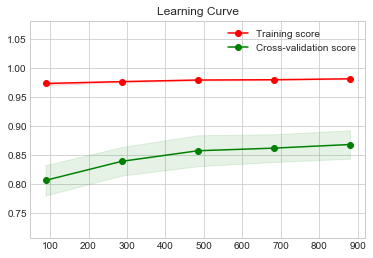

In [95]:
from sklearn.model_selection import StratifiedKFold, learning_curve
train_sizes, train_scores, validation_scores = learning_curve(rfreg_model, X_trainmodel,y_trainmodel.values.ravel(),cv=10)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [109]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators": [1500],
    "max_depth": [3,5,7,10],
    
    "min_samples_split": [3,5,7],
    "min_samples_leaf": [3,5,7],
    "max_features":[20]
             }

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

grid.fit(X=X_trainmodel, y = y_trainmodel)

print(grid.best_score_)
print(grid.best_params_)
best_model = grid.best_estimator_
print(best_model)

0.867963394856
{'min_samples_split': 5, 'max_depth': 10, 'min_samples_leaf': 3, 'max_features': 20, 'n_estimators': 1500}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [110]:
best_model.fit(X = X_trainmodel,y = y_trainmodel)
y_pred_val= best_model.predict(X= X_val)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

RMSLE Value For Random Forest:  0.13222935926


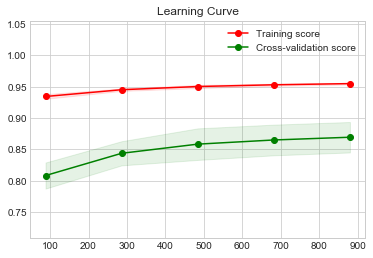

In [111]:
from sklearn.model_selection import StratifiedKFold, learning_curve
train_sizes, train_scores, validation_scores = learning_curve(best_model, X_trainmodel,y_trainmodel.values.ravel(),cv=10)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [112]:
y_pred_result = best_model.predict(X=test_X)

In [113]:
y_pred_result = np.exp(y_pred_result)-1
print(y_pred_result[1:10])
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_housing"+timestamp+"_out.csv"
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": y_pred_result
    })
submission.to_csv(filename, index=False)


[ 156587.8079  182102.5178  184079.5056  190184.1035  181703.0108
  173102.9291  174036.1713  184300.3136  122550.8827]


In [ ]:
[ 157424.0683  182097.3233  184189.5451  190035.2155  181514.6726
  171076.8006  173651.299   183379.2339  122906.8508]